Model-driven strategies have long been the classic framework to address the derivation of governing equations. However, the ever increasing availability of large-scale observation and simulation datasets makes more and more appealing the development of data-driven strategies especially when dealing with computationally-demanding models or phenomenons with high modeling uncertainties. 

The use of a given identification scheme is strongly conditioned by the nature of the provided observations. In this context, let us start by introducing the following state space model formulation

\begin{equation}
\left \{
\begin{array}{ccl}
\dot{{z}_{t}} &= {f}({z}_{t}, \eta_t)\\
{x}_{t} &= \mathcal{H}({z}_{t},\epsilon_{t})
\label{eq:C10_SSM}
\end{array}\right.
\end{equation}

where $z \in \mathbb{R}^{s}$ and $x \in \mathbb{R}^{n}$ represent the hidden state variables and the observations respectively, $f$ and $\mathcal{H}$ the dynamical and observation models. $\eta_t$ and $\epsilon_{t}$ are random process accounting for the uncertainties in the dynamical and observation models respectively. 

In an identification scenario, neither the dynamical model $f_{\theta}$, nor the state variables ${z}$ are known. Instead, we are only provided with the observations ${x}$ that are related in some way to the hidden states through the observation operator $\mathcal{H}$ and the noise $\epsilon$. Furthermore, the dynamical model noise $\eta_t$ can account for either i) errors in modeling a deterministic real phenomenon or ii) stochastic variability of the data. In the latter case, deterministic modeling techniques can only express the variability of the mean component and stochastic identification techniques need to be used. In this work however, we mostly focus on deterministic representations and we assume for the rest of this section that the noise $\eta$ can be neglected i.e. $\eta = 0$. 

Depending on the nature of the observation operator $\mathcal{H}$ and the noise $\epsilon$, several data-driven schemes could be considered. In this context, this notebook we will introduce a some considerations regarding the provided observations and the corresponding identification technique.

# 1) Data generation

In [9]:
from Generate_data import generate_data
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.integrate import odeint
from utils import RMSE
from tqdm import tqdm

In [2]:
# dataset parameters
class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = 0.01 # sampling time
    nb_loop_train = 100.01 #7500.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    
# run the data generation
catalog, xt = generate_data(GD)
# catalog is the true states zt, it containts a time sliced data base : 
# catalog.analogs    == zt
# catalog.successors == zt+n*dt_integration
# xt is the test set

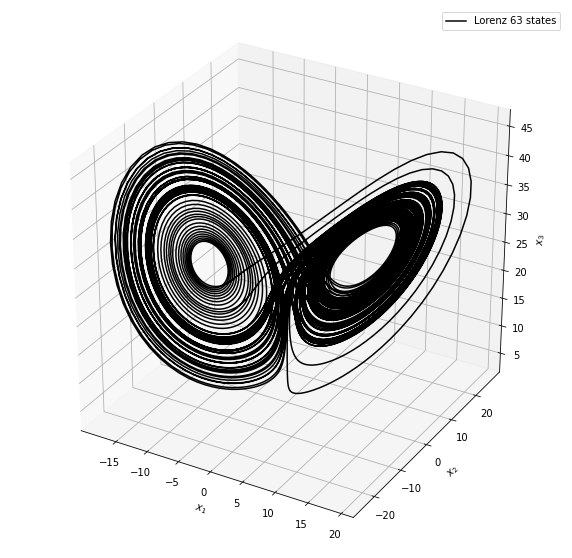

In [3]:
# plot
fig=plt.figure(figsize=(10,10))
ax=fig.gca(projection='3d')
line1,=ax.plot(catalog.analogs[:,0],catalog.analogs[:,1],catalog.analogs[:,2],'k')
ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1], ['Lorenz 63 states'])

When provided with direct measurements of the state vector ${z}$ (typically when the observation operator $\mathcal{H}$ is the identity matrix and the observation noise $\epsilon$ is zero), the problem may be regarded as the identification of the most appropriate basis function that will explain the temporal variability of the observations. Formally, the above state space model can be rewritten as follows:
\begin{equation}
\left \{
\begin{array}{ccl}
\dot{{z}_{t}} &= {f_{\theta}}({z}_{t})\\
{x}_{t} &= {z}_{t}
\label{eq:C2_dm_SSM_identity}
\end{array}\right.
\end{equation}

In this scenario, and given an approximation $f_{\theta}$ of the underlying dynamical function $f$, a data driven representation typically aims at minimizing a forecasting cost of the following form:
\begin{equation}
    \displaystyle \min_{\theta} \sum_{n=1}^N \| {z}_{t_{n}} - \Phi_{\theta,t_n}({z}_{t_{n-1}})\| 
    \label{eq:opti_case_Identity}
\end{equation}
where $\Phi_{\theta,t_n}({z}_{t_{n-1}}) = {z}_{t_{n-1}} + \int_{t_{n-1}}^{t_n}f_{\theta}({z}_{w})dw$.

Or, in a differential form : 
\begin{equation}
    \displaystyle \min_{\theta} \sum_{n=1}^N \| \dot{{z}_{t}} - {f_{\theta}}({z}_{t})\| 
\end{equation}

where $\dot{{z}_{t}}$ is estimated from data.

# 2) Dictionary based linear regression
## 2.1) Linear model

A first category of identification methods involves global parametric representations derived from physical principles where polynomial representations are typical examples. In the following we consider the identification of a dynamical system using linear regression i.e. $f_{\theta} = A$ where A is a matrix. For this purpose we use the SINDy library of (Steven L. Brunton et al. 2016)

In [67]:
from SINDy import *

In [95]:
t_data       = np.arange(0,catalog.analogs.shape[0],1)*GD.dt_integration # needed in SINDy
data         = np.transpose(np.insert(np.array([catalog.analogs[:,0] , catalog.analogs[:,1] , catalog.analogs[:,2]]),0,t_data,axis=0))
ddata        = np.zeros([catalog.analogs.shape[0],catalog.analogs.shape[-1]+1])
ddata[:,1:]  = np.gradient(data[:,1:])[0]/GD.dt_integration

# Here sparsity_itterations is set to 0 to mimic a classical least square optimization
# Polyorder  = 1 : Linear model
sin = SINDy(data=data,polyorder=1,usesine=False,cutoff=0.02, sparsity_itterations = 0)
sin.SetDerivative(ddata)
sin.RunSINDy(simulate=False)

def Identified_Model(y,t, sin) :
    y=np.reshape(y,(1,y.shape[-1]))
    aug=sin.PoolData(y)    
    dy = np.dot(aug,sin._xi)
    return np.reshape(dy,(y.shape[-1]))

Initiated a class for Sparse Identification from Numerical Dynamics
**** Derivative Set ****
**** Candidate functions library has been created ****
**** Performing regression. Please wait... ****
Iteration in progress: 



In [91]:
init_cond   = xt.values[0,:]
end_time    = 10
S_lin_Model = odeint(Identified_Model,init_cond,np.arange(0.01,end_time+0.000001,GD.dt_integration),args=(sin,)); 

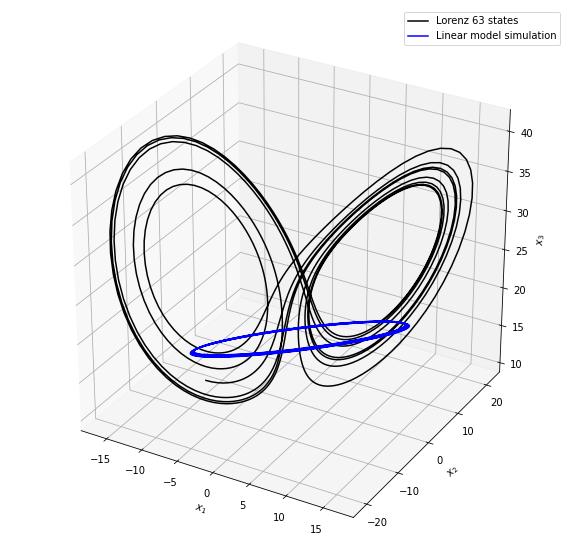

In [92]:
# plot
fig=plt.figure(figsize=(10,10))
ax=fig.gca(projection='3d')
line1,=ax.plot(xt.values[:1000,0],xt.values[:1000,1],xt.values[:1000,2],'k')
line2,=ax.plot(S_lin_Model[:1000,0],S_lin_Model[:1000,1],S_lin_Model[:1000,2],'b')
ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1,line2], ['Lorenz 63 states', 'Linear model simulation'])

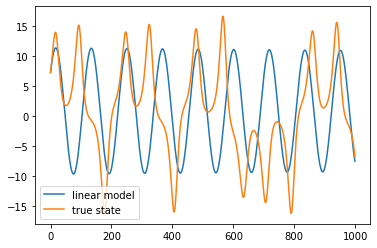

In [114]:
#" short term forecast : "
plt.plot(S_lin_Model[:1000,0],label ='linear model' )
plt.plot(xt.values[:1000,0],label ='true state')
plt.legend()

## 2.2) Linear regression on a polynomial basis  
The linear model is not able to capture the chaotic behaviough of the states (which is expected). We move now to a linear regression on a polynomial basis, i.e. 

\begin{equation}
\dot{{z}_{t}} = A(Poly({z}_{t}))
\label{eq:C2_dm_SSM_identity}
\end{equation}
where $Poly({z}_{t})$ is an augmented representation of ${z}_{t}$ that contains polynomials of the states of $z$ up to a given order. $A$ is computed using least squares.

In [98]:
t_data       = np.arange(0,catalog.analogs.shape[0],1)*GD.dt_integration # needed in SINDy
data         = np.transpose(np.insert(np.array([catalog.analogs[:,0] , catalog.analogs[:,1] , catalog.analogs[:,2]]),0,t_data,axis=0))
ddata        = np.zeros([catalog.analogs.shape[0],catalog.analogs.shape[-1]+1])
ddata[:,1:]  = np.gradient(data[:,1:])[0]/GD.dt_integration

# Here sparsity_itterations is set to 0 to mimic a classical least square optimization
# Polyorder  = 2 : 2nd order polynomial representation

sin = SINDy(data=data,polyorder=2,usesine=False,cutoff=0.02, sparsity_itterations = 0)
sin.SetDerivative(ddata)
sin.RunSINDy(simulate=False)

def Identified_Model(y,t, sin) :
    y=np.reshape(y,(1,y.shape[-1]))
    aug=sin.PoolData(y)    
    dy = np.dot(aug,sin._xi)
    return np.reshape(dy,(y.shape[-1]))

Initiated a class for Sparse Identification from Numerical Dynamics
**** Derivative Set ****
**** Candidate functions library has been created ****
**** Performing regression. Please wait... ****
Iteration in progress: 



In [100]:
init_cond   = xt.values[0,:]
end_time    = 10
S_Poly2_Model = odeint(Identified_Model,init_cond,np.arange(0.01,end_time+0.000001,GD.dt_integration),args=(sin,)); 

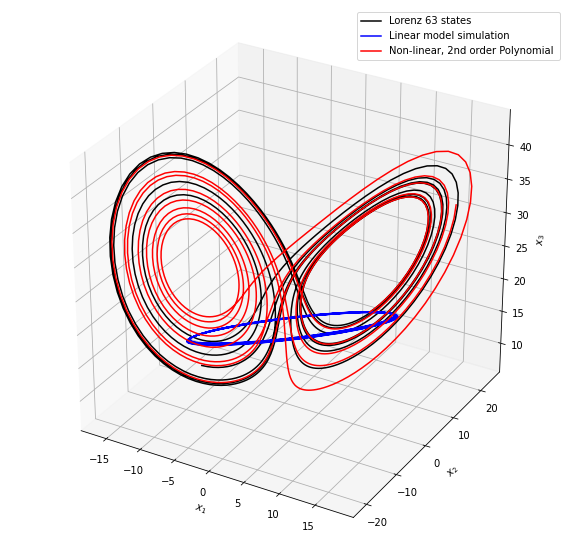

In [103]:
# plot
fig=plt.figure(figsize=(10,10))
ax=fig.gca(projection='3d')
line1,=ax.plot(xt.values[:1000,0],xt.values[:1000,1],xt.values[:1000,2],'k')
line2,=ax.plot(S_lin_Model[:1000,0],S_lin_Model[:1000,1],S_lin_Model[:1000,2],'b')
line3,=ax.plot(S_Poly2_Model[:1000,0],S_Poly2_Model[:1000,1],S_Poly2_Model[:1000,2],'r')

ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1,line2,line3], ['Lorenz 63 states', 'Linear model simulation', 'Non-linear, 2nd order Polynomial '])

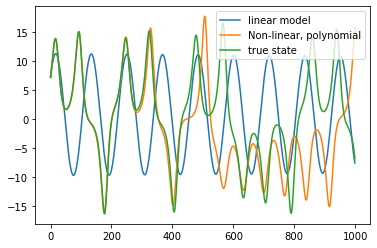

In [112]:
#" short term forecast : "
plt.plot(S_lin_Model[:1000,0],label ='linear model' )
plt.plot(S_Poly2_Model[:1000,0],label ='Non-linear, polynomial')
plt.plot(xt.values[:1000,0],label ='true state')
plt.legend()

## 2.3) Sparse identification of the dynamics !
The 2nd order polynomial model does a good job! this is due to the fact that the non-linearity present in the "unknown" Lorenz 63 equations is quadratic and is present in the dictionnary Poly({z}_{t}), making the inversion from the observations straightforward.

Bonus : including sparsity using threshholded least squares :

In [106]:
t_data       = np.arange(0,catalog.analogs.shape[0],1)*GD.dt_integration # needed in SINDy
data         = np.transpose(np.insert(np.array([catalog.analogs[:,0] , catalog.analogs[:,1] , catalog.analogs[:,2]]),0,t_data,axis=0))
ddata        = np.zeros([catalog.analogs.shape[0],catalog.analogs.shape[-1]+1])
ddata[:,1:]  = np.gradient(data[:,1:])[0]/GD.dt_integration

# Here sparsity_itterations is set to 10 sparse identification
# Polyorder  = 2 : 2nd order polynomial representation

sin = SINDy(data=data,polyorder=2,usesine=False,cutoff=0.02, sparsity_itterations = 10)
sin.SetDerivative(ddata)
sin.RunSINDy(simulate=False)

def Identified_Model(y,t, sin) :
    y=np.reshape(y,(1,y.shape[-1]))
    aug=sin.PoolData(y)    
    dy = np.dot(aug,sin._xi)
    return np.reshape(dy,(y.shape[-1]))

Initiated a class for Sparse Identification from Numerical Dynamics
**** Derivative Set ****
**** Candidate functions library has been created ****
**** Performing regression. Please wait... ****
Iteration in progress: 
1,
2,
3,
4,
5,
6,
7,
8,
9,
10,



In [107]:
init_cond   = xt.values[0,:]
end_time    = 10
S_Poly2_Model_sparse = odeint(Identified_Model,init_cond,np.arange(0.01,end_time+0.000001,GD.dt_integration),args=(sin,)); 

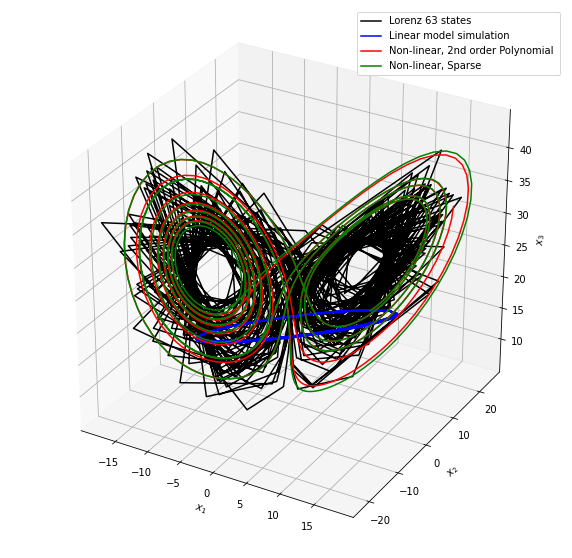

In [136]:
# plot
fig=plt.figure(figsize=(10,10))
ax=fig.gca(projection='3d')
line1,=ax.plot(xt.values[:1000,0],xt.values[:1000,1],xt.values[:1000,2],'k')
line2,=ax.plot(S_lin_Model[:1000,0],S_lin_Model[:1000,1],S_lin_Model[:1000,2],'b')
line3,=ax.plot(S_Poly2_Model[:1000,0],S_Poly2_Model[:1000,1],S_Poly2_Model[:1000,2],'r')
line4,=ax.plot(S_Poly2_Model_sparse[:1000,0],S_Poly2_Model_sparse[:1000,1],S_Poly2_Model_sparse[:1000,2],'g')

ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1,line2,line3,line4], ['Lorenz 63 states', 'Linear model simulation', 'Non-linear, 2nd order Polynomial ',  'Non-linear, Sparse '])

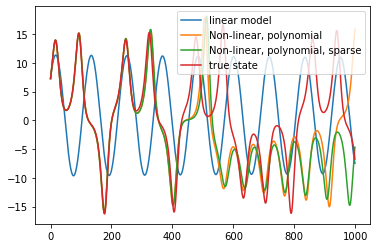

In [115]:
#" short term forecast : "
plt.plot(S_lin_Model[:1000,0],label ='linear model' )
plt.plot(S_Poly2_Model[:1000,0],label ='Non-linear, polynomial')
plt.plot(S_Poly2_Model_sparse[:1000,0],label ='Non-linear, polynomial, sparse')
plt.plot(xt.values[:1000,0],label ='true state')
plt.legend()

## 2.4 Question : Find the coefficients of the sparse regression and compare to the true model !

# 3) Limitations of regression techniques and neural representations 

Beyond the issus related to the prior parameterization of the dictionnary of non-linear terms, linear regression techiques fail when given noisy/partial observations of the state $z_t$ since the estimation of the derivatives become impossible. From this point of view, neural ODE models approximate the flowmap $\Phi_{\theta,t_n}({z}_{t_{n-1}}) = {z}_{t_{n-1}} + \int_{t_{n-1}}^{t_n}f_{\theta}({z}_{w})dw$ using a given integration routine. In order to highlight this aspect we consider the following case study with sparse in time data :

In [278]:
# dataset parameters
class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = 0.2 # sparse sampling time
    nb_loop_train = 400.01 #7500.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    
# run the data generation
catalog, xt = generate_data(GD)
# catalog is the true states zt, it containts a time sliced data base : 
# catalog.analogs    == zt
# catalog.successors == zt+n*dt_integration
# xt is the test set

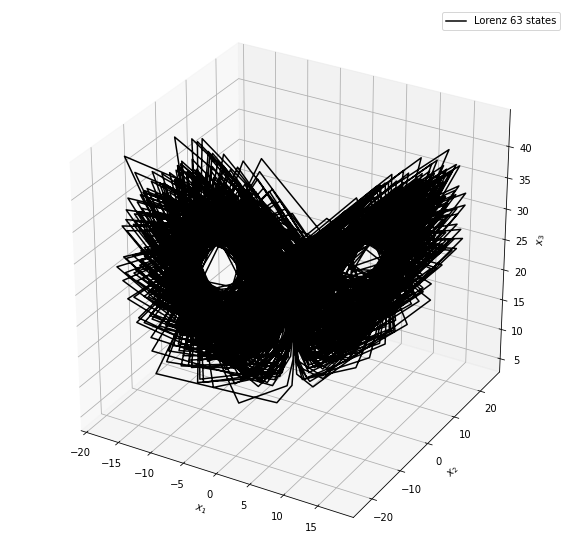

In [164]:
# plot
fig=plt.figure(figsize=(10,10))
ax=fig.gca(projection='3d')
line1,=ax.plot(catalog.analogs[:,0],catalog.analogs[:,1],catalog.analogs[:,2],'k')
ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1], ['Lorenz 63 states'])

In [165]:
t_data       = np.arange(0,catalog.analogs.shape[0],1)*GD.dt_integration # needed in SINDy
data         = np.transpose(np.insert(np.array([catalog.analogs[:,0] , catalog.analogs[:,1] , catalog.analogs[:,2]]),0,t_data,axis=0))
ddata        = np.zeros([catalog.analogs.shape[0],catalog.analogs.shape[-1]+1])
ddata[:,1:]  = np.gradient(data[:,1:])[0]/GD.dt_integration

# Here sparsity_itterations is set to 0 to mimic a classical least square optimization
# Polyorder  = 2 : 2nd order polynomial representation

sin = SINDy(data=data,polyorder=2,usesine=False,cutoff=0.02, sparsity_itterations = 10)
sin.SetDerivative(ddata)
sin.RunSINDy(simulate=False)

def Identified_Model(y,t, sin) :
    y=np.reshape(y,(1,y.shape[-1]))
    aug=sin.PoolData(y)    
    dy = np.dot(aug,sin._xi)
    return np.reshape(dy,(y.shape[-1]))

Initiated a class for Sparse Identification from Numerical Dynamics
**** Derivative Set ****
**** Candidate functions library has been created ****
**** Performing regression. Please wait... ****
Iteration in progress: 
1,
2,
3,
4,
5,
6,
7,
8,
9,
10,



In [166]:
init_cond   = xt.values[0,:]
end_time    = 100
S_Poly_sparse_data = odeint(Identified_Model,init_cond,np.arange(0.01,end_time+0.000001,GD.dt_integration),args=(sin,)); 

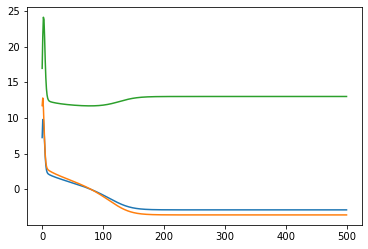

In [167]:
plt.plot(S_Poly_sparse_data)

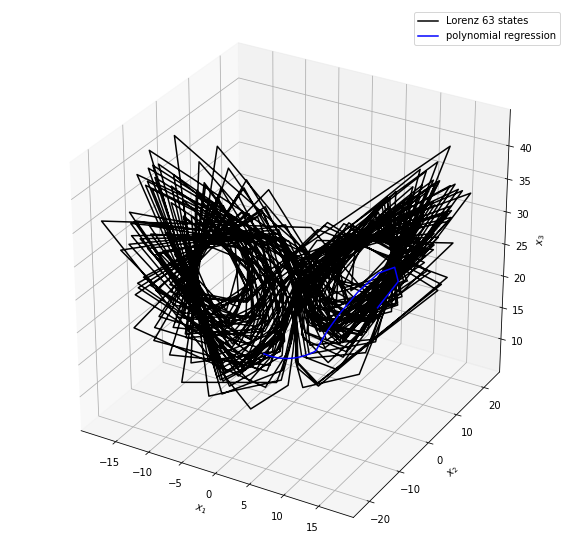

In [168]:
# plot
fig=plt.figure(figsize=(10,10))
ax=fig.gca(projection='3d')
line1,=ax.plot(xt.values[:1000,0],xt.values[:1000,1],xt.values[:1000,2],'k')
line2,=ax.plot(S_Poly_sparse_data[:1000,0],S_Poly_sparse_data[:1000,1],S_Poly_sparse_data[:1000,2],'b')

ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1,line2], ['Lorenz 63 states', 'polynomial regression'])

# 4) Neural ODE 
Even with the correct non-linearity, the linear regression technique can not work since the estimation of the derivatives is impossible given such sparse data. Two solutions are possible, the forst one is using a neural ODE model with an adaptive step size solver, or jointly learning the ODE model and the integration operator.

## 4.1) NODE model with fixed stepsize solver : RK4 
Here we consider the following problem:
\begin{equation}
\left \{
\begin{array}{ccl}
\dot{{z}_{t}} &=& {f_{\theta}}({z}_{t})\\
\Phi_{\theta,t_n}({z}_{t_{n-1}}) &=& {z}_{t_{n-1}} + \int_{t_{n-1}}^{t_n}f_{\theta}({z}_{w})dw
\label{eq:C2_dm_SSM_identity}
\end{array}\right.
\end{equation}

Where $f_{\theta}$ is a neural network and $\Phi$ the Runge Kutta 4 solver. Overall, the parameters of $f_{\theta}$ are optimized based on minimizing a forecasting cost of the following form:
\begin{equation}
    \displaystyle \min_{\theta} \sum_{n=1}^N \| {z}_{t_{n}} - \Phi_{\theta,t_n}({z}_{t_{n-1}})\| 
    \label{eq:opti_case_Identity}
\end{equation}

In [271]:
from torchdiffeq import odeint as odeintTorch

In [272]:
device = 'cuda:0'
params = {}#NN parameters 
params['transition_layers']=1
params['bi_linear_layers']=3
params['dim_hidden_linear'] = 3
params['dim_input']=3
params['dim_observations'] = 3
params['dim_output']=3
params['dim_hidden']=3
params['dt_integration']=GD.dt_integration
params['ntrain']=[10000]
params['pretrained']=False
params['path']='NODE_RK4_Lorend_dt_02'
params['lr']=0.001

In [274]:
class NODE_model(torch.nn.Module):
        def __init__(self, params):
            super(NODE_model, self).__init__()
            self.linearCell   = torch.nn.Linear(params['dim_input'], params['dim_hidden_linear']).to(device) 
            self.BlinearCell1 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1).to(device) for i in range(params['bi_linear_layers'])])
            self.BlinearCell2 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1).to(device) for i in range(params['bi_linear_layers'])])
            augmented_size    = params['bi_linear_layers'] + params['dim_hidden_linear']
            self.transLayers = torch.nn.ModuleList([torch.nn.Linear(augmented_size, params['dim_output']).to(device)])
            self.transLayers.extend([torch.nn.Linear(params['dim_output'], params['dim_output']).to(device) for i in range(1, params['transition_layers'])])
            self.outputLayer  = torch.nn.Linear(params['dim_output'], params['dim_output']).to(device)
        def forward(self,dt, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            BP_outp = (torch.zeros((inp.size()[0],params['bi_linear_layers'])).to(device))
            L_outp   = self.linearCell(inp)
            for i in range((params['bi_linear_layers'])):
                BP_outp[:,i]=self.BlinearCell1[i](inp)[:,0]*self.BlinearCell2[i](inp)[:,0]
            aug_vect = torch.cat((L_outp, BP_outp), dim=1)
            for i in range((params['transition_layers'])):
                aug_vect = (self.transLayers[i](aug_vect))
            grad = self.outputLayer(aug_vect)
            return grad
model  = NODE_model(params_RK4).to(device)


In [275]:
x = (torch.from_numpy(catalog.analogs).float().to(device).unsqueeze(0))
y = (torch.from_numpy(catalog.successors).float().to(device).unsqueeze(0))
if params_RK4['pretrained'] :
    model.load_state_dict(torch.load(params_RK4['path']+'.pt'))
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

dt = GD.dt_integration*np.arange(x.shape[1])
dt = torch.from_numpy(dt).float()
time  = dt[:2]

In [276]:
print ('Learning dynamical model')
for t in range(params['ntrain'][0]):
        for b in range(x.shape[0]):
            # Forward pass: Compute predicted gradients by passing x to the model
            pred = odeintTorch(model, x[b,:,:], time, method='rk4')#modelRINN(x[b,:,:],params['dt_integration'],order)
            loss = criterion(pred[1,:,:], y[b,:,:])
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(t,loss)
        torch.save(model.state_dict(), params_RK4['path']+'.pt')

Learning dynamical model
0 tensor(109.4174, device='cuda:0', grad_fn=<MseLossBackward0>)
1 tensor(108.7180, device='cuda:0', grad_fn=<MseLossBackward0>)
2 tensor(108.0349, device='cuda:0', grad_fn=<MseLossBackward0>)
3 tensor(107.3681, device='cuda:0', grad_fn=<MseLossBackward0>)
4 tensor(106.7175, device='cuda:0', grad_fn=<MseLossBackward0>)
5 tensor(106.0831, device='cuda:0', grad_fn=<MseLossBackward0>)
6 tensor(105.4647, device='cuda:0', grad_fn=<MseLossBackward0>)
7 tensor(104.8621, device='cuda:0', grad_fn=<MseLossBackward0>)
8 tensor(104.2751, device='cuda:0', grad_fn=<MseLossBackward0>)
9 

/homes/s17ouala/miniconda3/envs/DYN_ID2/lib/python3.7/site-packages/torchdiffeq/_impl/misc.py:237: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


tensor(103.7034, device='cuda:0', grad_fn=<MseLossBackward0>)
10 tensor(103.1467, device='cuda:0', grad_fn=<MseLossBackward0>)
11 tensor(102.6048, device='cuda:0', grad_fn=<MseLossBackward0>)
12 tensor(102.0774, device='cuda:0', grad_fn=<MseLossBackward0>)
13 tensor(101.5641, device='cuda:0', grad_fn=<MseLossBackward0>)
14 tensor(101.0646, device='cuda:0', grad_fn=<MseLossBackward0>)
15 tensor(100.5787, device='cuda:0', grad_fn=<MseLossBackward0>)
16 tensor(100.1060, device='cuda:0', grad_fn=<MseLossBackward0>)
17 tensor(99.6462, device='cuda:0', grad_fn=<MseLossBackward0>)
18 tensor(99.1990, device='cuda:0', grad_fn=<MseLossBackward0>)
19 tensor(98.7640, device='cuda:0', grad_fn=<MseLossBackward0>)
20 tensor(98.3410, device='cuda:0', grad_fn=<MseLossBackward0>)
21 tensor(97.9297, device='cuda:0', grad_fn=<MseLossBackward0>)
22 tensor(97.5297, device='cuda:0', grad_fn=<MseLossBackward0>)
23 tensor(97.1407, device='cuda:0', grad_fn=<MseLossBackward0>)
24 tensor(96.7625, device='cuda:0',

141 tensor(80.7200, device='cuda:0', grad_fn=<MseLossBackward0>)
142 tensor(80.6644, device='cuda:0', grad_fn=<MseLossBackward0>)
143 tensor(80.6089, device='cuda:0', grad_fn=<MseLossBackward0>)
144 tensor(80.5535, device='cuda:0', grad_fn=<MseLossBackward0>)
145 tensor(80.4983, device='cuda:0', grad_fn=<MseLossBackward0>)
146 tensor(80.4432, device='cuda:0', grad_fn=<MseLossBackward0>)
147 tensor(80.3882, device='cuda:0', grad_fn=<MseLossBackward0>)
148 tensor(80.3333, device='cuda:0', grad_fn=<MseLossBackward0>)
149 tensor(80.2784, device='cuda:0', grad_fn=<MseLossBackward0>)
150 tensor(80.2236, device='cuda:0', grad_fn=<MseLossBackward0>)
151 tensor(80.1689, device='cuda:0', grad_fn=<MseLossBackward0>)
152 tensor(80.1141, device='cuda:0', grad_fn=<MseLossBackward0>)
153 tensor(80.0594, device='cuda:0', grad_fn=<MseLossBackward0>)
154 tensor(80.0047, device='cuda:0', grad_fn=<MseLossBackward0>)
155 tensor(79.9499, device='cuda:0', grad_fn=<MseLossBackward0>)
156 tensor(79.8952, devic

277 tensor(64.7641, device='cuda:0', grad_fn=<MseLossBackward0>)
278 tensor(64.4781, device='cuda:0', grad_fn=<MseLossBackward0>)
279 tensor(64.1899, device='cuda:0', grad_fn=<MseLossBackward0>)
280 tensor(63.8995, device='cuda:0', grad_fn=<MseLossBackward0>)
281 tensor(63.6072, device='cuda:0', grad_fn=<MseLossBackward0>)
282 tensor(63.3131, device='cuda:0', grad_fn=<MseLossBackward0>)
283 tensor(63.0174, device='cuda:0', grad_fn=<MseLossBackward0>)
284 tensor(62.7203, device='cuda:0', grad_fn=<MseLossBackward0>)
285 tensor(62.4221, device='cuda:0', grad_fn=<MseLossBackward0>)
286 tensor(62.1229, device='cuda:0', grad_fn=<MseLossBackward0>)
287 tensor(61.8230, device='cuda:0', grad_fn=<MseLossBackward0>)
288 tensor(61.5226, device='cuda:0', grad_fn=<MseLossBackward0>)
289 tensor(61.2218, device='cuda:0', grad_fn=<MseLossBackward0>)
290 tensor(60.9210, device='cuda:0', grad_fn=<MseLossBackward0>)
291 tensor(60.6202, device='cuda:0', grad_fn=<MseLossBackward0>)
292 tensor(60.3199, devic

413 tensor(38.1472, device='cuda:0', grad_fn=<MseLossBackward0>)
414 tensor(38.0919, device='cuda:0', grad_fn=<MseLossBackward0>)
415 tensor(38.0383, device='cuda:0', grad_fn=<MseLossBackward0>)
416 tensor(37.9863, device='cuda:0', grad_fn=<MseLossBackward0>)
417 tensor(37.9358, device='cuda:0', grad_fn=<MseLossBackward0>)
418 tensor(37.8868, device='cuda:0', grad_fn=<MseLossBackward0>)
419 tensor(37.8390, device='cuda:0', grad_fn=<MseLossBackward0>)
420 tensor(37.7925, device='cuda:0', grad_fn=<MseLossBackward0>)
421 tensor(37.7471, device='cuda:0', grad_fn=<MseLossBackward0>)
422 tensor(37.7028, device='cuda:0', grad_fn=<MseLossBackward0>)
423 tensor(37.6596, device='cuda:0', grad_fn=<MseLossBackward0>)
424 tensor(37.6172, device='cuda:0', grad_fn=<MseLossBackward0>)
425 tensor(37.5757, device='cuda:0', grad_fn=<MseLossBackward0>)
426 tensor(37.5350, device='cuda:0', grad_fn=<MseLossBackward0>)
427 tensor(37.4950, device='cuda:0', grad_fn=<MseLossBackward0>)
428 tensor(37.4557, devic

547 tensor(34.0171, device='cuda:0', grad_fn=<MseLossBackward0>)
548 tensor(33.9996, device='cuda:0', grad_fn=<MseLossBackward0>)
549 tensor(33.9823, device='cuda:0', grad_fn=<MseLossBackward0>)
550 tensor(33.9651, device='cuda:0', grad_fn=<MseLossBackward0>)
551 tensor(33.9479, device='cuda:0', grad_fn=<MseLossBackward0>)
552 tensor(33.9309, device='cuda:0', grad_fn=<MseLossBackward0>)
553 tensor(33.9140, device='cuda:0', grad_fn=<MseLossBackward0>)
554 tensor(33.8972, device='cuda:0', grad_fn=<MseLossBackward0>)
555 tensor(33.8806, device='cuda:0', grad_fn=<MseLossBackward0>)
556 tensor(33.8640, device='cuda:0', grad_fn=<MseLossBackward0>)
557 tensor(33.8475, device='cuda:0', grad_fn=<MseLossBackward0>)
558 tensor(33.8312, device='cuda:0', grad_fn=<MseLossBackward0>)
559 tensor(33.8149, device='cuda:0', grad_fn=<MseLossBackward0>)
560 tensor(33.7988, device='cuda:0', grad_fn=<MseLossBackward0>)
561 tensor(33.7828, device='cuda:0', grad_fn=<MseLossBackward0>)
562 tensor(33.7669, devic

682 tensor(32.5061, device='cuda:0', grad_fn=<MseLossBackward0>)
683 tensor(32.4991, device='cuda:0', grad_fn=<MseLossBackward0>)
684 tensor(32.4921, device='cuda:0', grad_fn=<MseLossBackward0>)
685 tensor(32.4852, device='cuda:0', grad_fn=<MseLossBackward0>)
686 tensor(32.4783, device='cuda:0', grad_fn=<MseLossBackward0>)
687 tensor(32.4714, device='cuda:0', grad_fn=<MseLossBackward0>)
688 tensor(32.4645, device='cuda:0', grad_fn=<MseLossBackward0>)
689 tensor(32.4576, device='cuda:0', grad_fn=<MseLossBackward0>)
690 tensor(32.4508, device='cuda:0', grad_fn=<MseLossBackward0>)
691 tensor(32.4440, device='cuda:0', grad_fn=<MseLossBackward0>)
692 tensor(32.4372, device='cuda:0', grad_fn=<MseLossBackward0>)
693 tensor(32.4304, device='cuda:0', grad_fn=<MseLossBackward0>)
694 tensor(32.4237, device='cuda:0', grad_fn=<MseLossBackward0>)
695 tensor(32.4169, device='cuda:0', grad_fn=<MseLossBackward0>)
696 tensor(32.4102, device='cuda:0', grad_fn=<MseLossBackward0>)
697 tensor(32.4035, devic

814 tensor(31.6832, device='cuda:0', grad_fn=<MseLossBackward0>)
815 tensor(31.6774, device='cuda:0', grad_fn=<MseLossBackward0>)
816 tensor(31.6716, device='cuda:0', grad_fn=<MseLossBackward0>)
817 tensor(31.6658, device='cuda:0', grad_fn=<MseLossBackward0>)
818 tensor(31.6600, device='cuda:0', grad_fn=<MseLossBackward0>)
819 tensor(31.6542, device='cuda:0', grad_fn=<MseLossBackward0>)
820 tensor(31.6485, device='cuda:0', grad_fn=<MseLossBackward0>)
821 tensor(31.6427, device='cuda:0', grad_fn=<MseLossBackward0>)
822 tensor(31.6369, device='cuda:0', grad_fn=<MseLossBackward0>)
823 tensor(31.6312, device='cuda:0', grad_fn=<MseLossBackward0>)
824 tensor(31.6254, device='cuda:0', grad_fn=<MseLossBackward0>)
825 tensor(31.6197, device='cuda:0', grad_fn=<MseLossBackward0>)
826 tensor(31.6139, device='cuda:0', grad_fn=<MseLossBackward0>)
827 tensor(31.6082, device='cuda:0', grad_fn=<MseLossBackward0>)
828 tensor(31.6024, device='cuda:0', grad_fn=<MseLossBackward0>)
829 tensor(31.5967, devic

946 tensor(30.9366, device='cuda:0', grad_fn=<MseLossBackward0>)
947 tensor(30.9308, device='cuda:0', grad_fn=<MseLossBackward0>)
948 tensor(30.9251, device='cuda:0', grad_fn=<MseLossBackward0>)
949 tensor(30.9193, device='cuda:0', grad_fn=<MseLossBackward0>)
950 tensor(30.9134, device='cuda:0', grad_fn=<MseLossBackward0>)
951 tensor(30.9076, device='cuda:0', grad_fn=<MseLossBackward0>)
952 tensor(30.9018, device='cuda:0', grad_fn=<MseLossBackward0>)
953 tensor(30.8960, device='cuda:0', grad_fn=<MseLossBackward0>)
954 tensor(30.8901, device='cuda:0', grad_fn=<MseLossBackward0>)
955 tensor(30.8843, device='cuda:0', grad_fn=<MseLossBackward0>)
956 tensor(30.8784, device='cuda:0', grad_fn=<MseLossBackward0>)
957 tensor(30.8725, device='cuda:0', grad_fn=<MseLossBackward0>)
958 tensor(30.8667, device='cuda:0', grad_fn=<MseLossBackward0>)
959 tensor(30.8608, device='cuda:0', grad_fn=<MseLossBackward0>)
960 tensor(30.8549, device='cuda:0', grad_fn=<MseLossBackward0>)
961 tensor(30.8490, devic

1078 tensor(30.0109, device='cuda:0', grad_fn=<MseLossBackward0>)
1079 tensor(30.0014, device='cuda:0', grad_fn=<MseLossBackward0>)
1080 tensor(29.9918, device='cuda:0', grad_fn=<MseLossBackward0>)
1081 tensor(29.9822, device='cuda:0', grad_fn=<MseLossBackward0>)
1082 tensor(29.9726, device='cuda:0', grad_fn=<MseLossBackward0>)
1083 tensor(29.9631, device='cuda:0', grad_fn=<MseLossBackward0>)
1084 tensor(29.9538, device='cuda:0', grad_fn=<MseLossBackward0>)
1085 tensor(29.9451, device='cuda:0', grad_fn=<MseLossBackward0>)
1086 tensor(29.9381, device='cuda:0', grad_fn=<MseLossBackward0>)
1087 tensor(29.9355, device='cuda:0', grad_fn=<MseLossBackward0>)
1088 tensor(29.9412, device='cuda:0', grad_fn=<MseLossBackward0>)
1089 tensor(29.9548, device='cuda:0', grad_fn=<MseLossBackward0>)
1090 tensor(29.9509, device='cuda:0', grad_fn=<MseLossBackward0>)
1091 tensor(29.9085, device='cuda:0', grad_fn=<MseLossBackward0>)
1092 tensor(29.8755, device='cuda:0', grad_fn=<MseLossBackward0>)
1093 tenso

1210 tensor(28.7018, device='cuda:0', grad_fn=<MseLossBackward0>)
1211 tensor(28.6902, device='cuda:0', grad_fn=<MseLossBackward0>)
1212 tensor(28.6784, device='cuda:0', grad_fn=<MseLossBackward0>)
1213 tensor(28.6666, device='cuda:0', grad_fn=<MseLossBackward0>)
1214 tensor(28.6548, device='cuda:0', grad_fn=<MseLossBackward0>)
1215 tensor(28.6429, device='cuda:0', grad_fn=<MseLossBackward0>)
1216 tensor(28.6310, device='cuda:0', grad_fn=<MseLossBackward0>)
1217 tensor(28.6191, device='cuda:0', grad_fn=<MseLossBackward0>)
1218 tensor(28.6070, device='cuda:0', grad_fn=<MseLossBackward0>)
1219 tensor(28.5950, device='cuda:0', grad_fn=<MseLossBackward0>)
1220 tensor(28.5829, device='cuda:0', grad_fn=<MseLossBackward0>)
1221 tensor(28.5707, device='cuda:0', grad_fn=<MseLossBackward0>)
1222 tensor(28.5585, device='cuda:0', grad_fn=<MseLossBackward0>)
1223 tensor(28.5463, device='cuda:0', grad_fn=<MseLossBackward0>)
1224 tensor(28.5340, device='cuda:0', grad_fn=<MseLossBackward0>)
1225 tenso

1339 tensor(26.7545, device='cuda:0', grad_fn=<MseLossBackward0>)
1340 tensor(26.7363, device='cuda:0', grad_fn=<MseLossBackward0>)
1341 tensor(26.7181, device='cuda:0', grad_fn=<MseLossBackward0>)
1342 tensor(26.6999, device='cuda:0', grad_fn=<MseLossBackward0>)
1343 tensor(26.6817, device='cuda:0', grad_fn=<MseLossBackward0>)
1344 tensor(26.6635, device='cuda:0', grad_fn=<MseLossBackward0>)
1345 tensor(26.6453, device='cuda:0', grad_fn=<MseLossBackward0>)
1346 tensor(26.6270, device='cuda:0', grad_fn=<MseLossBackward0>)
1347 tensor(26.6088, device='cuda:0', grad_fn=<MseLossBackward0>)
1348 tensor(26.5905, device='cuda:0', grad_fn=<MseLossBackward0>)
1349 tensor(26.5723, device='cuda:0', grad_fn=<MseLossBackward0>)
1350 tensor(26.5540, device='cuda:0', grad_fn=<MseLossBackward0>)
1351 tensor(26.5357, device='cuda:0', grad_fn=<MseLossBackward0>)
1352 tensor(26.5175, device='cuda:0', grad_fn=<MseLossBackward0>)
1353 tensor(26.4992, device='cuda:0', grad_fn=<MseLossBackward0>)
1354 tenso

1469 tensor(24.7456, device='cuda:0', grad_fn=<MseLossBackward0>)
1470 tensor(24.7350, device='cuda:0', grad_fn=<MseLossBackward0>)
1471 tensor(24.7243, device='cuda:0', grad_fn=<MseLossBackward0>)
1472 tensor(24.7136, device='cuda:0', grad_fn=<MseLossBackward0>)
1473 tensor(24.7032, device='cuda:0', grad_fn=<MseLossBackward0>)
1474 tensor(24.6929, device='cuda:0', grad_fn=<MseLossBackward0>)
1475 tensor(24.6825, device='cuda:0', grad_fn=<MseLossBackward0>)
1476 tensor(24.6721, device='cuda:0', grad_fn=<MseLossBackward0>)
1477 tensor(24.6619, device='cuda:0', grad_fn=<MseLossBackward0>)
1478 tensor(24.6518, device='cuda:0', grad_fn=<MseLossBackward0>)
1479 tensor(24.6417, device='cuda:0', grad_fn=<MseLossBackward0>)
1480 tensor(24.6316, device='cuda:0', grad_fn=<MseLossBackward0>)
1481 tensor(24.6216, device='cuda:0', grad_fn=<MseLossBackward0>)
1482 tensor(24.6117, device='cuda:0', grad_fn=<MseLossBackward0>)
1483 tensor(24.6018, device='cuda:0', grad_fn=<MseLossBackward0>)
1484 tenso

1599 tensor(23.7222, device='cuda:0', grad_fn=<MseLossBackward0>)
1600 tensor(23.7160, device='cuda:0', grad_fn=<MseLossBackward0>)
1601 tensor(23.7098, device='cuda:0', grad_fn=<MseLossBackward0>)
1602 tensor(23.7037, device='cuda:0', grad_fn=<MseLossBackward0>)
1603 tensor(23.6975, device='cuda:0', grad_fn=<MseLossBackward0>)
1604 tensor(23.6914, device='cuda:0', grad_fn=<MseLossBackward0>)
1605 tensor(23.6852, device='cuda:0', grad_fn=<MseLossBackward0>)
1606 tensor(23.6791, device='cuda:0', grad_fn=<MseLossBackward0>)
1607 tensor(23.6730, device='cuda:0', grad_fn=<MseLossBackward0>)
1608 tensor(23.6669, device='cuda:0', grad_fn=<MseLossBackward0>)
1609 tensor(23.6608, device='cuda:0', grad_fn=<MseLossBackward0>)
1610 tensor(23.6547, device='cuda:0', grad_fn=<MseLossBackward0>)
1611 tensor(23.6487, device='cuda:0', grad_fn=<MseLossBackward0>)
1612 tensor(23.6426, device='cuda:0', grad_fn=<MseLossBackward0>)
1613 tensor(23.6366, device='cuda:0', grad_fn=<MseLossBackward0>)
1614 tenso

1729 tensor(22.9946, device='cuda:0', grad_fn=<MseLossBackward0>)
1730 tensor(22.9895, device='cuda:0', grad_fn=<MseLossBackward0>)
1731 tensor(22.9844, device='cuda:0', grad_fn=<MseLossBackward0>)
1732 tensor(22.9793, device='cuda:0', grad_fn=<MseLossBackward0>)
1733 tensor(22.9742, device='cuda:0', grad_fn=<MseLossBackward0>)
1734 tensor(22.9691, device='cuda:0', grad_fn=<MseLossBackward0>)
1735 tensor(22.9640, device='cuda:0', grad_fn=<MseLossBackward0>)
1736 tensor(22.9589, device='cuda:0', grad_fn=<MseLossBackward0>)
1737 tensor(22.9538, device='cuda:0', grad_fn=<MseLossBackward0>)
1738 tensor(22.9488, device='cuda:0', grad_fn=<MseLossBackward0>)
1739 tensor(22.9437, device='cuda:0', grad_fn=<MseLossBackward0>)
1740 tensor(22.9386, device='cuda:0', grad_fn=<MseLossBackward0>)
1741 tensor(22.9336, device='cuda:0', grad_fn=<MseLossBackward0>)
1742 tensor(22.9285, device='cuda:0', grad_fn=<MseLossBackward0>)
1743 tensor(22.9235, device='cuda:0', grad_fn=<MseLossBackward0>)
1744 tenso

1858 tensor(22.3814, device='cuda:0', grad_fn=<MseLossBackward0>)
1859 tensor(22.3769, device='cuda:0', grad_fn=<MseLossBackward0>)
1860 tensor(22.3725, device='cuda:0', grad_fn=<MseLossBackward0>)
1861 tensor(22.3681, device='cuda:0', grad_fn=<MseLossBackward0>)
1862 tensor(22.3637, device='cuda:0', grad_fn=<MseLossBackward0>)
1863 tensor(22.3593, device='cuda:0', grad_fn=<MseLossBackward0>)
1864 tensor(22.3550, device='cuda:0', grad_fn=<MseLossBackward0>)
1865 tensor(22.3506, device='cuda:0', grad_fn=<MseLossBackward0>)
1866 tensor(22.3462, device='cuda:0', grad_fn=<MseLossBackward0>)
1867 tensor(22.3418, device='cuda:0', grad_fn=<MseLossBackward0>)
1868 tensor(22.3375, device='cuda:0', grad_fn=<MseLossBackward0>)
1869 tensor(22.3331, device='cuda:0', grad_fn=<MseLossBackward0>)
1870 tensor(22.3287, device='cuda:0', grad_fn=<MseLossBackward0>)
1871 tensor(22.3244, device='cuda:0', grad_fn=<MseLossBackward0>)
1872 tensor(22.3200, device='cuda:0', grad_fn=<MseLossBackward0>)
1873 tenso

1984 tensor(21.8579, device='cuda:0', grad_fn=<MseLossBackward0>)
1985 tensor(21.8540, device='cuda:0', grad_fn=<MseLossBackward0>)
1986 tensor(21.8501, device='cuda:0', grad_fn=<MseLossBackward0>)
1987 tensor(21.8461, device='cuda:0', grad_fn=<MseLossBackward0>)
1988 tensor(21.8422, device='cuda:0', grad_fn=<MseLossBackward0>)
1989 tensor(21.8383, device='cuda:0', grad_fn=<MseLossBackward0>)
1990 tensor(21.8344, device='cuda:0', grad_fn=<MseLossBackward0>)
1991 tensor(21.8305, device='cuda:0', grad_fn=<MseLossBackward0>)
1992 tensor(21.8266, device='cuda:0', grad_fn=<MseLossBackward0>)
1993 tensor(21.8227, device='cuda:0', grad_fn=<MseLossBackward0>)
1994 tensor(21.8188, device='cuda:0', grad_fn=<MseLossBackward0>)
1995 tensor(21.8149, device='cuda:0', grad_fn=<MseLossBackward0>)
1996 tensor(21.8110, device='cuda:0', grad_fn=<MseLossBackward0>)
1997 tensor(21.8071, device='cuda:0', grad_fn=<MseLossBackward0>)
1998 tensor(21.8032, device='cuda:0', grad_fn=<MseLossBackward0>)
1999 tenso

2117 tensor(21.3803, device='cuda:0', grad_fn=<MseLossBackward0>)
2118 tensor(21.3771, device='cuda:0', grad_fn=<MseLossBackward0>)
2119 tensor(21.3739, device='cuda:0', grad_fn=<MseLossBackward0>)
2120 tensor(21.3707, device='cuda:0', grad_fn=<MseLossBackward0>)
2121 tensor(21.3675, device='cuda:0', grad_fn=<MseLossBackward0>)
2122 tensor(21.3643, device='cuda:0', grad_fn=<MseLossBackward0>)
2123 tensor(21.3612, device='cuda:0', grad_fn=<MseLossBackward0>)
2124 tensor(21.3580, device='cuda:0', grad_fn=<MseLossBackward0>)
2125 tensor(21.3548, device='cuda:0', grad_fn=<MseLossBackward0>)
2126 tensor(21.3516, device='cuda:0', grad_fn=<MseLossBackward0>)
2127 tensor(21.3485, device='cuda:0', grad_fn=<MseLossBackward0>)
2128 tensor(21.3453, device='cuda:0', grad_fn=<MseLossBackward0>)
2129 tensor(21.3422, device='cuda:0', grad_fn=<MseLossBackward0>)
2130 tensor(21.3391, device='cuda:0', grad_fn=<MseLossBackward0>)
2131 tensor(21.3359, device='cuda:0', grad_fn=<MseLossBackward0>)
2132 tenso

2250 tensor(21.0004, device='cuda:0', grad_fn=<MseLossBackward0>)
2251 tensor(20.9980, device='cuda:0', grad_fn=<MseLossBackward0>)
2252 tensor(20.9956, device='cuda:0', grad_fn=<MseLossBackward0>)
2253 tensor(20.9930, device='cuda:0', grad_fn=<MseLossBackward0>)
2254 tensor(20.9904, device='cuda:0', grad_fn=<MseLossBackward0>)
2255 tensor(20.9878, device='cuda:0', grad_fn=<MseLossBackward0>)
2256 tensor(20.9853, device='cuda:0', grad_fn=<MseLossBackward0>)
2257 tensor(20.9829, device='cuda:0', grad_fn=<MseLossBackward0>)
2258 tensor(20.9804, device='cuda:0', grad_fn=<MseLossBackward0>)
2259 tensor(20.9779, device='cuda:0', grad_fn=<MseLossBackward0>)
2260 tensor(20.9754, device='cuda:0', grad_fn=<MseLossBackward0>)
2261 tensor(20.9728, device='cuda:0', grad_fn=<MseLossBackward0>)
2262 tensor(20.9703, device='cuda:0', grad_fn=<MseLossBackward0>)
2263 tensor(20.9679, device='cuda:0', grad_fn=<MseLossBackward0>)
2264 tensor(20.9654, device='cuda:0', grad_fn=<MseLossBackward0>)
2265 tenso

2379 tensor(20.6858, device='cuda:0', grad_fn=<MseLossBackward0>)
2380 tensor(20.6812, device='cuda:0', grad_fn=<MseLossBackward0>)
2381 tensor(20.6756, device='cuda:0', grad_fn=<MseLossBackward0>)
2382 tensor(20.6714, device='cuda:0', grad_fn=<MseLossBackward0>)
2383 tensor(20.6694, device='cuda:0', grad_fn=<MseLossBackward0>)
2384 tensor(20.6685, device='cuda:0', grad_fn=<MseLossBackward0>)
2385 tensor(20.6670, device='cuda:0', grad_fn=<MseLossBackward0>)
2386 tensor(20.6639, device='cuda:0', grad_fn=<MseLossBackward0>)
2387 tensor(20.6598, device='cuda:0', grad_fn=<MseLossBackward0>)
2388 tensor(20.6560, device='cuda:0', grad_fn=<MseLossBackward0>)
2389 tensor(20.6535, device='cuda:0', grad_fn=<MseLossBackward0>)
2390 tensor(20.6517, device='cuda:0', grad_fn=<MseLossBackward0>)
2391 tensor(20.6499, device='cuda:0', grad_fn=<MseLossBackward0>)
2392 tensor(20.6472, device='cuda:0', grad_fn=<MseLossBackward0>)
2393 tensor(20.6439, device='cuda:0', grad_fn=<MseLossBackward0>)
2394 tenso

2509 tensor(20.2912, device='cuda:0', grad_fn=<MseLossBackward0>)
2510 tensor(20.2876, device='cuda:0', grad_fn=<MseLossBackward0>)
2511 tensor(20.2839, device='cuda:0', grad_fn=<MseLossBackward0>)
2512 tensor(20.2803, device='cuda:0', grad_fn=<MseLossBackward0>)
2513 tensor(20.2766, device='cuda:0', grad_fn=<MseLossBackward0>)
2514 tensor(20.2730, device='cuda:0', grad_fn=<MseLossBackward0>)
2515 tensor(20.2693, device='cuda:0', grad_fn=<MseLossBackward0>)
2516 tensor(20.2656, device='cuda:0', grad_fn=<MseLossBackward0>)
2517 tensor(20.2619, device='cuda:0', grad_fn=<MseLossBackward0>)
2518 tensor(20.2581, device='cuda:0', grad_fn=<MseLossBackward0>)
2519 tensor(20.2544, device='cuda:0', grad_fn=<MseLossBackward0>)
2520 tensor(20.2507, device='cuda:0', grad_fn=<MseLossBackward0>)
2521 tensor(20.2469, device='cuda:0', grad_fn=<MseLossBackward0>)
2522 tensor(20.2431, device='cuda:0', grad_fn=<MseLossBackward0>)
2523 tensor(20.2393, device='cuda:0', grad_fn=<MseLossBackward0>)
2524 tenso

2636 tensor(19.7106, device='cuda:0', grad_fn=<MseLossBackward0>)
2637 tensor(19.7050, device='cuda:0', grad_fn=<MseLossBackward0>)
2638 tensor(19.6994, device='cuda:0', grad_fn=<MseLossBackward0>)
2639 tensor(19.6938, device='cuda:0', grad_fn=<MseLossBackward0>)
2640 tensor(19.6882, device='cuda:0', grad_fn=<MseLossBackward0>)
2641 tensor(19.6825, device='cuda:0', grad_fn=<MseLossBackward0>)
2642 tensor(19.6768, device='cuda:0', grad_fn=<MseLossBackward0>)
2643 tensor(19.6711, device='cuda:0', grad_fn=<MseLossBackward0>)
2644 tensor(19.6654, device='cuda:0', grad_fn=<MseLossBackward0>)
2645 tensor(19.6597, device='cuda:0', grad_fn=<MseLossBackward0>)
2646 tensor(19.6540, device='cuda:0', grad_fn=<MseLossBackward0>)
2647 tensor(19.6482, device='cuda:0', grad_fn=<MseLossBackward0>)
2648 tensor(19.6425, device='cuda:0', grad_fn=<MseLossBackward0>)
2649 tensor(19.6367, device='cuda:0', grad_fn=<MseLossBackward0>)
2650 tensor(19.6309, device='cuda:0', grad_fn=<MseLossBackward0>)
2651 tenso

2772 tensor(18.8716, device='cuda:0', grad_fn=<MseLossBackward0>)
2773 tensor(18.8654, device='cuda:0', grad_fn=<MseLossBackward0>)
2774 tensor(18.8592, device='cuda:0', grad_fn=<MseLossBackward0>)
2775 tensor(18.8530, device='cuda:0', grad_fn=<MseLossBackward0>)
2776 tensor(18.8468, device='cuda:0', grad_fn=<MseLossBackward0>)
2777 tensor(18.8407, device='cuda:0', grad_fn=<MseLossBackward0>)
2778 tensor(18.8345, device='cuda:0', grad_fn=<MseLossBackward0>)
2779 tensor(18.8283, device='cuda:0', grad_fn=<MseLossBackward0>)
2780 tensor(18.8222, device='cuda:0', grad_fn=<MseLossBackward0>)
2781 tensor(18.8161, device='cuda:0', grad_fn=<MseLossBackward0>)
2782 tensor(18.8099, device='cuda:0', grad_fn=<MseLossBackward0>)
2783 tensor(18.8038, device='cuda:0', grad_fn=<MseLossBackward0>)
2784 tensor(18.7977, device='cuda:0', grad_fn=<MseLossBackward0>)
2785 tensor(18.7916, device='cuda:0', grad_fn=<MseLossBackward0>)
2786 tensor(18.7855, device='cuda:0', grad_fn=<MseLossBackward0>)
2787 tenso

2902 tensor(18.1431, device='cuda:0', grad_fn=<MseLossBackward0>)
2903 tensor(18.1382, device='cuda:0', grad_fn=<MseLossBackward0>)
2904 tensor(18.1333, device='cuda:0', grad_fn=<MseLossBackward0>)
2905 tensor(18.1284, device='cuda:0', grad_fn=<MseLossBackward0>)
2906 tensor(18.1236, device='cuda:0', grad_fn=<MseLossBackward0>)
2907 tensor(18.1187, device='cuda:0', grad_fn=<MseLossBackward0>)
2908 tensor(18.1139, device='cuda:0', grad_fn=<MseLossBackward0>)
2909 tensor(18.1091, device='cuda:0', grad_fn=<MseLossBackward0>)
2910 tensor(18.1043, device='cuda:0', grad_fn=<MseLossBackward0>)
2911 tensor(18.0995, device='cuda:0', grad_fn=<MseLossBackward0>)
2912 tensor(18.0947, device='cuda:0', grad_fn=<MseLossBackward0>)
2913 tensor(18.0899, device='cuda:0', grad_fn=<MseLossBackward0>)
2914 tensor(18.0851, device='cuda:0', grad_fn=<MseLossBackward0>)
2915 tensor(18.0804, device='cuda:0', grad_fn=<MseLossBackward0>)
2916 tensor(18.0756, device='cuda:0', grad_fn=<MseLossBackward0>)
2917 tenso

3030 tensor(17.6158, device='cuda:0', grad_fn=<MseLossBackward0>)
3031 tensor(17.6125, device='cuda:0', grad_fn=<MseLossBackward0>)
3032 tensor(17.6092, device='cuda:0', grad_fn=<MseLossBackward0>)
3033 tensor(17.6059, device='cuda:0', grad_fn=<MseLossBackward0>)
3034 tensor(17.6026, device='cuda:0', grad_fn=<MseLossBackward0>)
3035 tensor(17.5993, device='cuda:0', grad_fn=<MseLossBackward0>)
3036 tensor(17.5961, device='cuda:0', grad_fn=<MseLossBackward0>)
3037 tensor(17.5928, device='cuda:0', grad_fn=<MseLossBackward0>)
3038 tensor(17.5896, device='cuda:0', grad_fn=<MseLossBackward0>)
3039 tensor(17.5864, device='cuda:0', grad_fn=<MseLossBackward0>)
3040 tensor(17.5832, device='cuda:0', grad_fn=<MseLossBackward0>)
3041 tensor(17.5800, device='cuda:0', grad_fn=<MseLossBackward0>)
3042 tensor(17.5769, device='cuda:0', grad_fn=<MseLossBackward0>)
3043 tensor(17.5737, device='cuda:0', grad_fn=<MseLossBackward0>)
3044 tensor(17.5706, device='cuda:0', grad_fn=<MseLossBackward0>)
3045 tenso

3160 tensor(17.3537, device='cuda:0', grad_fn=<MseLossBackward0>)
3161 tensor(17.3423, device='cuda:0', grad_fn=<MseLossBackward0>)
3162 tensor(17.3362, device='cuda:0', grad_fn=<MseLossBackward0>)
3163 tensor(17.3420, device='cuda:0', grad_fn=<MseLossBackward0>)
3164 tensor(17.3441, device='cuda:0', grad_fn=<MseLossBackward0>)
3165 tensor(17.3362, device='cuda:0', grad_fn=<MseLossBackward0>)
3166 tensor(17.3323, device='cuda:0', grad_fn=<MseLossBackward0>)
3167 tensor(17.3359, device='cuda:0', grad_fn=<MseLossBackward0>)
3168 tensor(17.3356, device='cuda:0', grad_fn=<MseLossBackward0>)
3169 tensor(17.3301, device='cuda:0', grad_fn=<MseLossBackward0>)
3170 tensor(17.3288, device='cuda:0', grad_fn=<MseLossBackward0>)
3171 tensor(17.3306, device='cuda:0', grad_fn=<MseLossBackward0>)
3172 tensor(17.3289, device='cuda:0', grad_fn=<MseLossBackward0>)
3173 tensor(17.3254, device='cuda:0', grad_fn=<MseLossBackward0>)
3174 tensor(17.3251, device='cuda:0', grad_fn=<MseLossBackward0>)
3175 tenso

3289 tensor(17.2410, device='cuda:0', grad_fn=<MseLossBackward0>)
3290 tensor(17.2404, device='cuda:0', grad_fn=<MseLossBackward0>)
3291 tensor(17.2399, device='cuda:0', grad_fn=<MseLossBackward0>)
3292 tensor(17.2393, device='cuda:0', grad_fn=<MseLossBackward0>)
3293 tensor(17.2388, device='cuda:0', grad_fn=<MseLossBackward0>)
3294 tensor(17.2382, device='cuda:0', grad_fn=<MseLossBackward0>)
3295 tensor(17.2377, device='cuda:0', grad_fn=<MseLossBackward0>)
3296 tensor(17.2371, device='cuda:0', grad_fn=<MseLossBackward0>)
3297 tensor(17.2366, device='cuda:0', grad_fn=<MseLossBackward0>)
3298 tensor(17.2361, device='cuda:0', grad_fn=<MseLossBackward0>)
3299 tensor(17.2355, device='cuda:0', grad_fn=<MseLossBackward0>)
3300 tensor(17.2350, device='cuda:0', grad_fn=<MseLossBackward0>)
3301 tensor(17.2345, device='cuda:0', grad_fn=<MseLossBackward0>)
3302 tensor(17.2339, device='cuda:0', grad_fn=<MseLossBackward0>)
3303 tensor(17.2334, device='cuda:0', grad_fn=<MseLossBackward0>)
3304 tenso

3414 tensor(17.1853, device='cuda:0', grad_fn=<MseLossBackward0>)
3415 tensor(17.1841, device='cuda:0', grad_fn=<MseLossBackward0>)
3416 tensor(17.1834, device='cuda:0', grad_fn=<MseLossBackward0>)
3417 tensor(17.1833, device='cuda:0', grad_fn=<MseLossBackward0>)
3418 tensor(17.1834, device='cuda:0', grad_fn=<MseLossBackward0>)
3419 tensor(17.1829, device='cuda:0', grad_fn=<MseLossBackward0>)
3420 tensor(17.1820, device='cuda:0', grad_fn=<MseLossBackward0>)
3421 tensor(17.1813, device='cuda:0', grad_fn=<MseLossBackward0>)
3422 tensor(17.1810, device='cuda:0', grad_fn=<MseLossBackward0>)
3423 tensor(17.1809, device='cuda:0', grad_fn=<MseLossBackward0>)
3424 tensor(17.1806, device='cuda:0', grad_fn=<MseLossBackward0>)
3425 tensor(17.1800, device='cuda:0', grad_fn=<MseLossBackward0>)
3426 tensor(17.1793, device='cuda:0', grad_fn=<MseLossBackward0>)
3427 tensor(17.1789, device='cuda:0', grad_fn=<MseLossBackward0>)
3428 tensor(17.1787, device='cuda:0', grad_fn=<MseLossBackward0>)
3429 tenso

3539 tensor(17.1412, device='cuda:0', grad_fn=<MseLossBackward0>)
3540 tensor(17.1409, device='cuda:0', grad_fn=<MseLossBackward0>)
3541 tensor(17.1406, device='cuda:0', grad_fn=<MseLossBackward0>)
3542 tensor(17.1402, device='cuda:0', grad_fn=<MseLossBackward0>)
3543 tensor(17.1399, device='cuda:0', grad_fn=<MseLossBackward0>)
3544 tensor(17.1396, device='cuda:0', grad_fn=<MseLossBackward0>)
3545 tensor(17.1393, device='cuda:0', grad_fn=<MseLossBackward0>)
3546 tensor(17.1390, device='cuda:0', grad_fn=<MseLossBackward0>)
3547 tensor(17.1387, device='cuda:0', grad_fn=<MseLossBackward0>)
3548 tensor(17.1384, device='cuda:0', grad_fn=<MseLossBackward0>)
3549 tensor(17.1381, device='cuda:0', grad_fn=<MseLossBackward0>)
3550 tensor(17.1378, device='cuda:0', grad_fn=<MseLossBackward0>)
3551 tensor(17.1375, device='cuda:0', grad_fn=<MseLossBackward0>)
3552 tensor(17.1372, device='cuda:0', grad_fn=<MseLossBackward0>)
3553 tensor(17.1369, device='cuda:0', grad_fn=<MseLossBackward0>)
3554 tenso

3674 tensor(17.1025, device='cuda:0', grad_fn=<MseLossBackward0>)
3675 tensor(17.1022, device='cuda:0', grad_fn=<MseLossBackward0>)
3676 tensor(17.1020, device='cuda:0', grad_fn=<MseLossBackward0>)
3677 tensor(17.1017, device='cuda:0', grad_fn=<MseLossBackward0>)
3678 tensor(17.1014, device='cuda:0', grad_fn=<MseLossBackward0>)
3679 tensor(17.1011, device='cuda:0', grad_fn=<MseLossBackward0>)
3680 tensor(17.1009, device='cuda:0', grad_fn=<MseLossBackward0>)
3681 tensor(17.1006, device='cuda:0', grad_fn=<MseLossBackward0>)
3682 tensor(17.1003, device='cuda:0', grad_fn=<MseLossBackward0>)
3683 tensor(17.1001, device='cuda:0', grad_fn=<MseLossBackward0>)
3684 tensor(17.0998, device='cuda:0', grad_fn=<MseLossBackward0>)
3685 tensor(17.0995, device='cuda:0', grad_fn=<MseLossBackward0>)
3686 tensor(17.0993, device='cuda:0', grad_fn=<MseLossBackward0>)
3687 tensor(17.0990, device='cuda:0', grad_fn=<MseLossBackward0>)
3688 tensor(17.0987, device='cuda:0', grad_fn=<MseLossBackward0>)
3689 tenso

3801 tensor(17.0695, device='cuda:0', grad_fn=<MseLossBackward0>)
3802 tensor(17.0692, device='cuda:0', grad_fn=<MseLossBackward0>)
3803 tensor(17.0690, device='cuda:0', grad_fn=<MseLossBackward0>)
3804 tensor(17.0687, device='cuda:0', grad_fn=<MseLossBackward0>)
3805 tensor(17.0685, device='cuda:0', grad_fn=<MseLossBackward0>)
3806 tensor(17.0682, device='cuda:0', grad_fn=<MseLossBackward0>)
3807 tensor(17.0679, device='cuda:0', grad_fn=<MseLossBackward0>)
3808 tensor(17.0677, device='cuda:0', grad_fn=<MseLossBackward0>)
3809 tensor(17.0674, device='cuda:0', grad_fn=<MseLossBackward0>)
3810 tensor(17.0672, device='cuda:0', grad_fn=<MseLossBackward0>)
3811 tensor(17.0669, device='cuda:0', grad_fn=<MseLossBackward0>)
3812 tensor(17.0667, device='cuda:0', grad_fn=<MseLossBackward0>)
3813 tensor(17.0664, device='cuda:0', grad_fn=<MseLossBackward0>)
3814 tensor(17.0662, device='cuda:0', grad_fn=<MseLossBackward0>)
3815 tensor(17.0659, device='cuda:0', grad_fn=<MseLossBackward0>)
3816 tenso

3929 tensor(17.0377, device='cuda:0', grad_fn=<MseLossBackward0>)
3930 tensor(17.0373, device='cuda:0', grad_fn=<MseLossBackward0>)
3931 tensor(17.0370, device='cuda:0', grad_fn=<MseLossBackward0>)
3932 tensor(17.0369, device='cuda:0', grad_fn=<MseLossBackward0>)
3933 tensor(17.0367, device='cuda:0', grad_fn=<MseLossBackward0>)
3934 tensor(17.0365, device='cuda:0', grad_fn=<MseLossBackward0>)
3935 tensor(17.0362, device='cuda:0', grad_fn=<MseLossBackward0>)
3936 tensor(17.0359, device='cuda:0', grad_fn=<MseLossBackward0>)
3937 tensor(17.0356, device='cuda:0', grad_fn=<MseLossBackward0>)
3938 tensor(17.0353, device='cuda:0', grad_fn=<MseLossBackward0>)
3939 tensor(17.0351, device='cuda:0', grad_fn=<MseLossBackward0>)
3940 tensor(17.0349, device='cuda:0', grad_fn=<MseLossBackward0>)
3941 tensor(17.0347, device='cuda:0', grad_fn=<MseLossBackward0>)
3942 tensor(17.0344, device='cuda:0', grad_fn=<MseLossBackward0>)
3943 tensor(17.0341, device='cuda:0', grad_fn=<MseLossBackward0>)
3944 tenso

4062 tensor(17.0072, device='cuda:0', grad_fn=<MseLossBackward0>)
4063 tensor(17.0053, device='cuda:0', grad_fn=<MseLossBackward0>)
4064 tensor(17.0046, device='cuda:0', grad_fn=<MseLossBackward0>)
4065 tensor(17.0053, device='cuda:0', grad_fn=<MseLossBackward0>)
4066 tensor(17.0063, device='cuda:0', grad_fn=<MseLossBackward0>)
4067 tensor(17.0064, device='cuda:0', grad_fn=<MseLossBackward0>)
4068 tensor(17.0052, device='cuda:0', grad_fn=<MseLossBackward0>)
4069 tensor(17.0035, device='cuda:0', grad_fn=<MseLossBackward0>)
4070 tensor(17.0025, device='cuda:0', grad_fn=<MseLossBackward0>)
4071 tensor(17.0027, device='cuda:0', grad_fn=<MseLossBackward0>)
4072 tensor(17.0033, device='cuda:0', grad_fn=<MseLossBackward0>)
4073 tensor(17.0035, device='cuda:0', grad_fn=<MseLossBackward0>)
4074 tensor(17.0028, device='cuda:0', grad_fn=<MseLossBackward0>)
4075 tensor(17.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
4076 tensor(17.0012, device='cuda:0', grad_fn=<MseLossBackward0>)
4077 tenso

4190 tensor(16.9813, device='cuda:0', grad_fn=<MseLossBackward0>)
4191 tensor(16.9756, device='cuda:0', grad_fn=<MseLossBackward0>)
4192 tensor(16.9717, device='cuda:0', grad_fn=<MseLossBackward0>)
4193 tensor(16.9713, device='cuda:0', grad_fn=<MseLossBackward0>)
4194 tensor(16.9734, device='cuda:0', grad_fn=<MseLossBackward0>)
4195 tensor(16.9760, device='cuda:0', grad_fn=<MseLossBackward0>)
4196 tensor(16.9773, device='cuda:0', grad_fn=<MseLossBackward0>)
4197 tensor(16.9759, device='cuda:0', grad_fn=<MseLossBackward0>)
4198 tensor(16.9729, device='cuda:0', grad_fn=<MseLossBackward0>)
4199 tensor(16.9700, device='cuda:0', grad_fn=<MseLossBackward0>)
4200 tensor(16.9690, device='cuda:0', grad_fn=<MseLossBackward0>)
4201 tensor(16.9698, device='cuda:0', grad_fn=<MseLossBackward0>)
4202 tensor(16.9713, device='cuda:0', grad_fn=<MseLossBackward0>)
4203 tensor(16.9719, device='cuda:0', grad_fn=<MseLossBackward0>)
4204 tensor(16.9708, device='cuda:0', grad_fn=<MseLossBackward0>)
4205 tenso

4322 tensor(16.9361, device='cuda:0', grad_fn=<MseLossBackward0>)
4323 tensor(16.9368, device='cuda:0', grad_fn=<MseLossBackward0>)
4324 tensor(16.9379, device='cuda:0', grad_fn=<MseLossBackward0>)
4325 tensor(16.9398, device='cuda:0', grad_fn=<MseLossBackward0>)
4326 tensor(16.9421, device='cuda:0', grad_fn=<MseLossBackward0>)
4327 tensor(16.9452, device='cuda:0', grad_fn=<MseLossBackward0>)
4328 tensor(16.9474, device='cuda:0', grad_fn=<MseLossBackward0>)
4329 tensor(16.9484, device='cuda:0', grad_fn=<MseLossBackward0>)
4330 tensor(16.9455, device='cuda:0', grad_fn=<MseLossBackward0>)
4331 tensor(16.9406, device='cuda:0', grad_fn=<MseLossBackward0>)
4332 tensor(16.9349, device='cuda:0', grad_fn=<MseLossBackward0>)
4333 tensor(16.9316, device='cuda:0', grad_fn=<MseLossBackward0>)
4334 tensor(16.9316, device='cuda:0', grad_fn=<MseLossBackward0>)
4335 tensor(16.9338, device='cuda:0', grad_fn=<MseLossBackward0>)
4336 tensor(16.9363, device='cuda:0', grad_fn=<MseLossBackward0>)
4337 tenso

4452 tensor(16.8931, device='cuda:0', grad_fn=<MseLossBackward0>)
4453 tensor(16.8928, device='cuda:0', grad_fn=<MseLossBackward0>)
4454 tensor(16.8926, device='cuda:0', grad_fn=<MseLossBackward0>)
4455 tensor(16.8925, device='cuda:0', grad_fn=<MseLossBackward0>)
4456 tensor(16.8926, device='cuda:0', grad_fn=<MseLossBackward0>)
4457 tensor(16.8928, device='cuda:0', grad_fn=<MseLossBackward0>)
4458 tensor(16.8933, device='cuda:0', grad_fn=<MseLossBackward0>)
4459 tensor(16.8942, device='cuda:0', grad_fn=<MseLossBackward0>)
4460 tensor(16.8956, device='cuda:0', grad_fn=<MseLossBackward0>)
4461 tensor(16.8975, device='cuda:0', grad_fn=<MseLossBackward0>)
4462 tensor(16.8999, device='cuda:0', grad_fn=<MseLossBackward0>)
4463 tensor(16.9017, device='cuda:0', grad_fn=<MseLossBackward0>)
4464 tensor(16.9029, device='cuda:0', grad_fn=<MseLossBackward0>)
4465 tensor(16.9010, device='cuda:0', grad_fn=<MseLossBackward0>)
4466 tensor(16.8974, device='cuda:0', grad_fn=<MseLossBackward0>)
4467 tenso

4579 tensor(16.8485, device='cuda:0', grad_fn=<MseLossBackward0>)
4580 tensor(16.8482, device='cuda:0', grad_fn=<MseLossBackward0>)
4581 tensor(16.8478, device='cuda:0', grad_fn=<MseLossBackward0>)
4582 tensor(16.8476, device='cuda:0', grad_fn=<MseLossBackward0>)
4583 tensor(16.8473, device='cuda:0', grad_fn=<MseLossBackward0>)
4584 tensor(16.8471, device='cuda:0', grad_fn=<MseLossBackward0>)
4585 tensor(16.8470, device='cuda:0', grad_fn=<MseLossBackward0>)
4586 tensor(16.8470, device='cuda:0', grad_fn=<MseLossBackward0>)
4587 tensor(16.8473, device='cuda:0', grad_fn=<MseLossBackward0>)
4588 tensor(16.8479, device='cuda:0', grad_fn=<MseLossBackward0>)
4589 tensor(16.8490, device='cuda:0', grad_fn=<MseLossBackward0>)
4590 tensor(16.8507, device='cuda:0', grad_fn=<MseLossBackward0>)
4591 tensor(16.8535, device='cuda:0', grad_fn=<MseLossBackward0>)
4592 tensor(16.8564, device='cuda:0', grad_fn=<MseLossBackward0>)
4593 tensor(16.8599, device='cuda:0', grad_fn=<MseLossBackward0>)
4594 tenso

4705 tensor(16.8053, device='cuda:0', grad_fn=<MseLossBackward0>)
4706 tensor(16.8050, device='cuda:0', grad_fn=<MseLossBackward0>)
4707 tensor(16.8047, device='cuda:0', grad_fn=<MseLossBackward0>)
4708 tensor(16.8043, device='cuda:0', grad_fn=<MseLossBackward0>)
4709 tensor(16.8040, device='cuda:0', grad_fn=<MseLossBackward0>)
4710 tensor(16.8037, device='cuda:0', grad_fn=<MseLossBackward0>)
4711 tensor(16.8034, device='cuda:0', grad_fn=<MseLossBackward0>)
4712 tensor(16.8030, device='cuda:0', grad_fn=<MseLossBackward0>)
4713 tensor(16.8027, device='cuda:0', grad_fn=<MseLossBackward0>)
4714 tensor(16.8024, device='cuda:0', grad_fn=<MseLossBackward0>)
4715 tensor(16.8020, device='cuda:0', grad_fn=<MseLossBackward0>)
4716 tensor(16.8017, device='cuda:0', grad_fn=<MseLossBackward0>)
4717 tensor(16.8014, device='cuda:0', grad_fn=<MseLossBackward0>)
4718 tensor(16.8011, device='cuda:0', grad_fn=<MseLossBackward0>)
4719 tensor(16.8007, device='cuda:0', grad_fn=<MseLossBackward0>)
4720 tenso

4834 tensor(16.7663, device='cuda:0', grad_fn=<MseLossBackward0>)
4835 tensor(16.7660, device='cuda:0', grad_fn=<MseLossBackward0>)
4836 tensor(16.7657, device='cuda:0', grad_fn=<MseLossBackward0>)
4837 tensor(16.7654, device='cuda:0', grad_fn=<MseLossBackward0>)
4838 tensor(16.7652, device='cuda:0', grad_fn=<MseLossBackward0>)
4839 tensor(16.7649, device='cuda:0', grad_fn=<MseLossBackward0>)
4840 tensor(16.7646, device='cuda:0', grad_fn=<MseLossBackward0>)
4841 tensor(16.7643, device='cuda:0', grad_fn=<MseLossBackward0>)
4842 tensor(16.7641, device='cuda:0', grad_fn=<MseLossBackward0>)
4843 tensor(16.7638, device='cuda:0', grad_fn=<MseLossBackward0>)
4844 tensor(16.7635, device='cuda:0', grad_fn=<MseLossBackward0>)
4845 tensor(16.7632, device='cuda:0', grad_fn=<MseLossBackward0>)
4846 tensor(16.7630, device='cuda:0', grad_fn=<MseLossBackward0>)
4847 tensor(16.7627, device='cuda:0', grad_fn=<MseLossBackward0>)
4848 tensor(16.7624, device='cuda:0', grad_fn=<MseLossBackward0>)
4849 tenso

4963 tensor(16.7350, device='cuda:0', grad_fn=<MseLossBackward0>)
4964 tensor(16.7342, device='cuda:0', grad_fn=<MseLossBackward0>)
4965 tensor(16.7336, device='cuda:0', grad_fn=<MseLossBackward0>)
4966 tensor(16.7333, device='cuda:0', grad_fn=<MseLossBackward0>)
4967 tensor(16.7334, device='cuda:0', grad_fn=<MseLossBackward0>)
4968 tensor(16.7334, device='cuda:0', grad_fn=<MseLossBackward0>)
4969 tensor(16.7332, device='cuda:0', grad_fn=<MseLossBackward0>)
4970 tensor(16.7327, device='cuda:0', grad_fn=<MseLossBackward0>)
4971 tensor(16.7323, device='cuda:0', grad_fn=<MseLossBackward0>)
4972 tensor(16.7320, device='cuda:0', grad_fn=<MseLossBackward0>)
4973 tensor(16.7318, device='cuda:0', grad_fn=<MseLossBackward0>)
4974 tensor(16.7317, device='cuda:0', grad_fn=<MseLossBackward0>)
4975 tensor(16.7316, device='cuda:0', grad_fn=<MseLossBackward0>)
4976 tensor(16.7313, device='cuda:0', grad_fn=<MseLossBackward0>)
4977 tensor(16.7310, device='cuda:0', grad_fn=<MseLossBackward0>)
4978 tenso

5091 tensor(16.7078, device='cuda:0', grad_fn=<MseLossBackward0>)
5092 tensor(16.7076, device='cuda:0', grad_fn=<MseLossBackward0>)
5093 tensor(16.7074, device='cuda:0', grad_fn=<MseLossBackward0>)
5094 tensor(16.7072, device='cuda:0', grad_fn=<MseLossBackward0>)
5095 tensor(16.7070, device='cuda:0', grad_fn=<MseLossBackward0>)
5096 tensor(16.7068, device='cuda:0', grad_fn=<MseLossBackward0>)
5097 tensor(16.7066, device='cuda:0', grad_fn=<MseLossBackward0>)
5098 tensor(16.7065, device='cuda:0', grad_fn=<MseLossBackward0>)
5099 tensor(16.7063, device='cuda:0', grad_fn=<MseLossBackward0>)
5100 tensor(16.7061, device='cuda:0', grad_fn=<MseLossBackward0>)
5101 tensor(16.7059, device='cuda:0', grad_fn=<MseLossBackward0>)
5102 tensor(16.7057, device='cuda:0', grad_fn=<MseLossBackward0>)
5103 tensor(16.7055, device='cuda:0', grad_fn=<MseLossBackward0>)
5104 tensor(16.7053, device='cuda:0', grad_fn=<MseLossBackward0>)
5105 tensor(16.7052, device='cuda:0', grad_fn=<MseLossBackward0>)
5106 tenso

5218 tensor(16.6856, device='cuda:0', grad_fn=<MseLossBackward0>)
5219 tensor(16.6855, device='cuda:0', grad_fn=<MseLossBackward0>)
5220 tensor(16.6853, device='cuda:0', grad_fn=<MseLossBackward0>)
5221 tensor(16.6852, device='cuda:0', grad_fn=<MseLossBackward0>)
5222 tensor(16.6850, device='cuda:0', grad_fn=<MseLossBackward0>)
5223 tensor(16.6848, device='cuda:0', grad_fn=<MseLossBackward0>)
5224 tensor(16.6847, device='cuda:0', grad_fn=<MseLossBackward0>)
5225 tensor(16.6845, device='cuda:0', grad_fn=<MseLossBackward0>)
5226 tensor(16.6843, device='cuda:0', grad_fn=<MseLossBackward0>)
5227 tensor(16.6842, device='cuda:0', grad_fn=<MseLossBackward0>)
5228 tensor(16.6840, device='cuda:0', grad_fn=<MseLossBackward0>)
5229 tensor(16.6838, device='cuda:0', grad_fn=<MseLossBackward0>)
5230 tensor(16.6837, device='cuda:0', grad_fn=<MseLossBackward0>)
5231 tensor(16.6835, device='cuda:0', grad_fn=<MseLossBackward0>)
5232 tensor(16.6834, device='cuda:0', grad_fn=<MseLossBackward0>)
5233 tenso

5344 tensor(16.6751, device='cuda:0', grad_fn=<MseLossBackward0>)
5345 tensor(16.6761, device='cuda:0', grad_fn=<MseLossBackward0>)
5346 tensor(16.6764, device='cuda:0', grad_fn=<MseLossBackward0>)
5347 tensor(16.6745, device='cuda:0', grad_fn=<MseLossBackward0>)
5348 tensor(16.6716, device='cuda:0', grad_fn=<MseLossBackward0>)
5349 tensor(16.6681, device='cuda:0', grad_fn=<MseLossBackward0>)
5350 tensor(16.6656, device='cuda:0', grad_fn=<MseLossBackward0>)
5351 tensor(16.6646, device='cuda:0', grad_fn=<MseLossBackward0>)
5352 tensor(16.6653, device='cuda:0', grad_fn=<MseLossBackward0>)
5353 tensor(16.6667, device='cuda:0', grad_fn=<MseLossBackward0>)
5354 tensor(16.6679, device='cuda:0', grad_fn=<MseLossBackward0>)
5355 tensor(16.6685, device='cuda:0', grad_fn=<MseLossBackward0>)
5356 tensor(16.6677, device='cuda:0', grad_fn=<MseLossBackward0>)
5357 tensor(16.6662, device='cuda:0', grad_fn=<MseLossBackward0>)
5358 tensor(16.6646, device='cuda:0', grad_fn=<MseLossBackward0>)
5359 tenso

5472 tensor(16.6464, device='cuda:0', grad_fn=<MseLossBackward0>)
5473 tensor(16.6463, device='cuda:0', grad_fn=<MseLossBackward0>)
5474 tensor(16.6461, device='cuda:0', grad_fn=<MseLossBackward0>)
5475 tensor(16.6460, device='cuda:0', grad_fn=<MseLossBackward0>)
5476 tensor(16.6458, device='cuda:0', grad_fn=<MseLossBackward0>)
5477 tensor(16.6457, device='cuda:0', grad_fn=<MseLossBackward0>)
5478 tensor(16.6455, device='cuda:0', grad_fn=<MseLossBackward0>)
5479 tensor(16.6454, device='cuda:0', grad_fn=<MseLossBackward0>)
5480 tensor(16.6452, device='cuda:0', grad_fn=<MseLossBackward0>)
5481 tensor(16.6451, device='cuda:0', grad_fn=<MseLossBackward0>)
5482 tensor(16.6449, device='cuda:0', grad_fn=<MseLossBackward0>)
5483 tensor(16.6448, device='cuda:0', grad_fn=<MseLossBackward0>)
5484 tensor(16.6446, device='cuda:0', grad_fn=<MseLossBackward0>)
5485 tensor(16.6445, device='cuda:0', grad_fn=<MseLossBackward0>)
5486 tensor(16.6443, device='cuda:0', grad_fn=<MseLossBackward0>)
5487 tenso

5597 tensor(16.6279, device='cuda:0', grad_fn=<MseLossBackward0>)
5598 tensor(16.6278, device='cuda:0', grad_fn=<MseLossBackward0>)
5599 tensor(16.6276, device='cuda:0', grad_fn=<MseLossBackward0>)
5600 tensor(16.6275, device='cuda:0', grad_fn=<MseLossBackward0>)
5601 tensor(16.6274, device='cuda:0', grad_fn=<MseLossBackward0>)
5602 tensor(16.6272, device='cuda:0', grad_fn=<MseLossBackward0>)
5603 tensor(16.6271, device='cuda:0', grad_fn=<MseLossBackward0>)
5604 tensor(16.6269, device='cuda:0', grad_fn=<MseLossBackward0>)
5605 tensor(16.6268, device='cuda:0', grad_fn=<MseLossBackward0>)
5606 tensor(16.6266, device='cuda:0', grad_fn=<MseLossBackward0>)
5607 tensor(16.6265, device='cuda:0', grad_fn=<MseLossBackward0>)
5608 tensor(16.6263, device='cuda:0', grad_fn=<MseLossBackward0>)
5609 tensor(16.6262, device='cuda:0', grad_fn=<MseLossBackward0>)
5610 tensor(16.6260, device='cuda:0', grad_fn=<MseLossBackward0>)
5611 tensor(16.6259, device='cuda:0', grad_fn=<MseLossBackward0>)
5612 tenso

5724 tensor(16.6091, device='cuda:0', grad_fn=<MseLossBackward0>)
5725 tensor(16.6091, device='cuda:0', grad_fn=<MseLossBackward0>)
5726 tensor(16.6090, device='cuda:0', grad_fn=<MseLossBackward0>)
5727 tensor(16.6088, device='cuda:0', grad_fn=<MseLossBackward0>)
5728 tensor(16.6086, device='cuda:0', grad_fn=<MseLossBackward0>)
5729 tensor(16.6084, device='cuda:0', grad_fn=<MseLossBackward0>)
5730 tensor(16.6082, device='cuda:0', grad_fn=<MseLossBackward0>)
5731 tensor(16.6080, device='cuda:0', grad_fn=<MseLossBackward0>)
5732 tensor(16.6079, device='cuda:0', grad_fn=<MseLossBackward0>)
5733 tensor(16.6078, device='cuda:0', grad_fn=<MseLossBackward0>)
5734 tensor(16.6077, device='cuda:0', grad_fn=<MseLossBackward0>)
5735 tensor(16.6075, device='cuda:0', grad_fn=<MseLossBackward0>)
5736 tensor(16.6073, device='cuda:0', grad_fn=<MseLossBackward0>)
5737 tensor(16.6072, device='cuda:0', grad_fn=<MseLossBackward0>)
5738 tensor(16.6070, device='cuda:0', grad_fn=<MseLossBackward0>)
5739 tenso

5849 tensor(16.5902, device='cuda:0', grad_fn=<MseLossBackward0>)
5850 tensor(16.5901, device='cuda:0', grad_fn=<MseLossBackward0>)
5851 tensor(16.5899, device='cuda:0', grad_fn=<MseLossBackward0>)
5852 tensor(16.5898, device='cuda:0', grad_fn=<MseLossBackward0>)
5853 tensor(16.5896, device='cuda:0', grad_fn=<MseLossBackward0>)
5854 tensor(16.5895, device='cuda:0', grad_fn=<MseLossBackward0>)
5855 tensor(16.5893, device='cuda:0', grad_fn=<MseLossBackward0>)
5856 tensor(16.5892, device='cuda:0', grad_fn=<MseLossBackward0>)
5857 tensor(16.5890, device='cuda:0', grad_fn=<MseLossBackward0>)
5858 tensor(16.5889, device='cuda:0', grad_fn=<MseLossBackward0>)
5859 tensor(16.5887, device='cuda:0', grad_fn=<MseLossBackward0>)
5860 tensor(16.5885, device='cuda:0', grad_fn=<MseLossBackward0>)
5861 tensor(16.5884, device='cuda:0', grad_fn=<MseLossBackward0>)
5862 tensor(16.5882, device='cuda:0', grad_fn=<MseLossBackward0>)
5863 tensor(16.5881, device='cuda:0', grad_fn=<MseLossBackward0>)
5864 tenso

5976 tensor(16.5717, device='cuda:0', grad_fn=<MseLossBackward0>)
5977 tensor(16.5719, device='cuda:0', grad_fn=<MseLossBackward0>)
5978 tensor(16.5723, device='cuda:0', grad_fn=<MseLossBackward0>)
5979 tensor(16.5728, device='cuda:0', grad_fn=<MseLossBackward0>)
5980 tensor(16.5735, device='cuda:0', grad_fn=<MseLossBackward0>)
5981 tensor(16.5741, device='cuda:0', grad_fn=<MseLossBackward0>)
5982 tensor(16.5748, device='cuda:0', grad_fn=<MseLossBackward0>)
5983 tensor(16.5750, device='cuda:0', grad_fn=<MseLossBackward0>)
5984 tensor(16.5751, device='cuda:0', grad_fn=<MseLossBackward0>)
5985 tensor(16.5743, device='cuda:0', grad_fn=<MseLossBackward0>)
5986 tensor(16.5732, device='cuda:0', grad_fn=<MseLossBackward0>)
5987 tensor(16.5716, device='cuda:0', grad_fn=<MseLossBackward0>)
5988 tensor(16.5701, device='cuda:0', grad_fn=<MseLossBackward0>)
5989 tensor(16.5689, device='cuda:0', grad_fn=<MseLossBackward0>)
5990 tensor(16.5683, device='cuda:0', grad_fn=<MseLossBackward0>)
5991 tenso

6102 tensor(16.5503, device='cuda:0', grad_fn=<MseLossBackward0>)
6103 tensor(16.5502, device='cuda:0', grad_fn=<MseLossBackward0>)
6104 tensor(16.5500, device='cuda:0', grad_fn=<MseLossBackward0>)
6105 tensor(16.5499, device='cuda:0', grad_fn=<MseLossBackward0>)
6106 tensor(16.5497, device='cuda:0', grad_fn=<MseLossBackward0>)
6107 tensor(16.5495, device='cuda:0', grad_fn=<MseLossBackward0>)
6108 tensor(16.5494, device='cuda:0', grad_fn=<MseLossBackward0>)
6109 tensor(16.5492, device='cuda:0', grad_fn=<MseLossBackward0>)
6110 tensor(16.5491, device='cuda:0', grad_fn=<MseLossBackward0>)
6111 tensor(16.5489, device='cuda:0', grad_fn=<MseLossBackward0>)
6112 tensor(16.5487, device='cuda:0', grad_fn=<MseLossBackward0>)
6113 tensor(16.5486, device='cuda:0', grad_fn=<MseLossBackward0>)
6114 tensor(16.5484, device='cuda:0', grad_fn=<MseLossBackward0>)
6115 tensor(16.5483, device='cuda:0', grad_fn=<MseLossBackward0>)
6116 tensor(16.5481, device='cuda:0', grad_fn=<MseLossBackward0>)
6117 tenso

6228 tensor(16.5296, device='cuda:0', grad_fn=<MseLossBackward0>)
6229 tensor(16.5294, device='cuda:0', grad_fn=<MseLossBackward0>)
6230 tensor(16.5293, device='cuda:0', grad_fn=<MseLossBackward0>)
6231 tensor(16.5291, device='cuda:0', grad_fn=<MseLossBackward0>)
6232 tensor(16.5289, device='cuda:0', grad_fn=<MseLossBackward0>)
6233 tensor(16.5287, device='cuda:0', grad_fn=<MseLossBackward0>)
6234 tensor(16.5286, device='cuda:0', grad_fn=<MseLossBackward0>)
6235 tensor(16.5284, device='cuda:0', grad_fn=<MseLossBackward0>)
6236 tensor(16.5282, device='cuda:0', grad_fn=<MseLossBackward0>)
6237 tensor(16.5281, device='cuda:0', grad_fn=<MseLossBackward0>)
6238 tensor(16.5279, device='cuda:0', grad_fn=<MseLossBackward0>)
6239 tensor(16.5277, device='cuda:0', grad_fn=<MseLossBackward0>)
6240 tensor(16.5276, device='cuda:0', grad_fn=<MseLossBackward0>)
6241 tensor(16.5274, device='cuda:0', grad_fn=<MseLossBackward0>)
6242 tensor(16.5272, device='cuda:0', grad_fn=<MseLossBackward0>)
6243 tenso

6354 tensor(16.5083, device='cuda:0', grad_fn=<MseLossBackward0>)
6355 tensor(16.5081, device='cuda:0', grad_fn=<MseLossBackward0>)
6356 tensor(16.5080, device='cuda:0', grad_fn=<MseLossBackward0>)
6357 tensor(16.5077, device='cuda:0', grad_fn=<MseLossBackward0>)
6358 tensor(16.5075, device='cuda:0', grad_fn=<MseLossBackward0>)
6359 tensor(16.5074, device='cuda:0', grad_fn=<MseLossBackward0>)
6360 tensor(16.5072, device='cuda:0', grad_fn=<MseLossBackward0>)
6361 tensor(16.5070, device='cuda:0', grad_fn=<MseLossBackward0>)
6362 tensor(16.5069, device='cuda:0', grad_fn=<MseLossBackward0>)
6363 tensor(16.5067, device='cuda:0', grad_fn=<MseLossBackward0>)
6364 tensor(16.5065, device='cuda:0', grad_fn=<MseLossBackward0>)
6365 tensor(16.5063, device='cuda:0', grad_fn=<MseLossBackward0>)
6366 tensor(16.5062, device='cuda:0', grad_fn=<MseLossBackward0>)
6367 tensor(16.5060, device='cuda:0', grad_fn=<MseLossBackward0>)
6368 tensor(16.5058, device='cuda:0', grad_fn=<MseLossBackward0>)
6369 tenso

6479 tensor(16.4867, device='cuda:0', grad_fn=<MseLossBackward0>)
6480 tensor(16.4866, device='cuda:0', grad_fn=<MseLossBackward0>)
6481 tensor(16.4865, device='cuda:0', grad_fn=<MseLossBackward0>)
6482 tensor(16.4864, device='cuda:0', grad_fn=<MseLossBackward0>)
6483 tensor(16.4863, device='cuda:0', grad_fn=<MseLossBackward0>)
6484 tensor(16.4863, device='cuda:0', grad_fn=<MseLossBackward0>)
6485 tensor(16.4864, device='cuda:0', grad_fn=<MseLossBackward0>)
6486 tensor(16.4865, device='cuda:0', grad_fn=<MseLossBackward0>)
6487 tensor(16.4868, device='cuda:0', grad_fn=<MseLossBackward0>)
6488 tensor(16.4872, device='cuda:0', grad_fn=<MseLossBackward0>)
6489 tensor(16.4877, device='cuda:0', grad_fn=<MseLossBackward0>)
6490 tensor(16.4883, device='cuda:0', grad_fn=<MseLossBackward0>)
6491 tensor(16.4889, device='cuda:0', grad_fn=<MseLossBackward0>)
6492 tensor(16.4894, device='cuda:0', grad_fn=<MseLossBackward0>)
6493 tensor(16.4894, device='cuda:0', grad_fn=<MseLossBackward0>)
6494 tenso

KeyboardInterrupt: 

In [279]:
dt_test     = GD.dt_integration*np.arange(xt.values.shape[0])
dt_test     = torch.from_numpy(dt_test).float().to(device)
init_cond   = (torch.from_numpy(xt.values[:1,:]).float().to(device))
S_NODE_RK4  = odeintTorch(model, init_cond, dt, method='rk4')

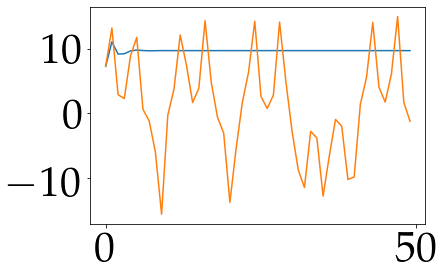

In [280]:
plt.plot(S_NODE_RK4.cpu().detach()[:50,0,0])
plt.plot(xt.values[:50,0])

## 4.2) Neural ODE with adaptive stepsize solver 

Here we consider the following problem:
\begin{equation}
\left \{
\begin{array}{ccl}
\dot{{z}_{t}} &=& {f_{\theta}}({z}_{t})\\
\Phi_{\theta,t_n}({z}_{t_{n-1}}) &=& {z}_{t_{n-1}} + \int_{t_{n-1}}^{t_n}f_{\theta}({z}_{w})dw
\label{eq:C2_dm_SSM_identity}
\end{array}\right.
\end{equation}

Where $f_{\theta}$ is a neural network and $\Phi$ is an adaptive stepsize solver. As seen above, fixed step size solvers such as Runge-Kutta 4 or Euler can have large truncation errors, making the identifiability impossible when given temporally sparse data, such integration techniques . Overall, the parameters of $f_{\theta}$ are optimized based on minimizing a forecasting cost of the following form:
\begin{equation}
    \displaystyle \min_{\theta} \sum_{n=1}^N \| {z}_{t_{n}} - \Phi_{\theta,t_n}({z}_{t_{n-1}})\| 
    \label{eq:opti_case_Identity}
\end{equation}

In [283]:
params['ntrain']=[200]
params['pretrained']=False
params['path']='NODE_Adaptive_Step_Size_Lorend_dt_01'

In [284]:
print ('Learning dynamical model')
for t in range(params['ntrain'][0]):
        for b in range(x.shape[0]):
            # Forward pass: Compute predicted gradients by passing x to the model
            pred = odeintTorch(model, x[b,:,:], time, method='dopri8')#modelRINN(x[b,:,:],params['dt_integration'],order)
            loss = criterion(pred[1,:,:], y[b,:,:])
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(t,loss)
        torch.save(model.state_dict(), params['path']+'.pt')

Learning dynamical model
44
0 tensor(19.8493, device='cuda:0', grad_fn=<MseLossBackward0>)
53
1 tensor(18.5581, device='cuda:0', grad_fn=<MseLossBackward0>)
47
2 tensor(17.7101, device='cuda:0', grad_fn=<MseLossBackward0>)
46
3 tensor(17.3224, device='cuda:0', grad_fn=<MseLossBackward0>)
44
4 tensor(17.1973, device='cuda:0', grad_fn=<MseLossBackward0>)
54
5 tensor(17.0017, device='cuda:0', grad_fn=<MseLossBackward0>)
54
6 tensor(16.4855, device='cuda:0', grad_fn=<MseLossBackward0>)
53
7 tensor(15.6529, device='cuda:0', grad_fn=<MseLossBackward0>)
56
8 tensor(14.7025, device='cuda:0', grad_fn=<MseLossBackward0>)
48
9 tensor(13.8641, device='cuda:0', grad_fn=<MseLossBackward0>)
48
10 tensor(13.2642, device='cuda:0', grad_fn=<MseLossBackward0>)
54
11 tensor(12.8657, device='cuda:0', grad_fn=<MseLossBackward0>)
60
12 tensor(12.5174, device='cuda:0', grad_fn=<MseLossBackward0>)
59
13 tensor(12.0871, device='cuda:0', grad_fn=<MseLossBackward0>)
56
14 tensor(11.5535, device='cuda:0', grad_fn=

70
124 tensor(2.1196, device='cuda:0', grad_fn=<MseLossBackward0>)
76
125 tensor(2.0937, device='cuda:0', grad_fn=<MseLossBackward0>)
69
126 tensor(2.0683, device='cuda:0', grad_fn=<MseLossBackward0>)
60
127 tensor(2.0433, device='cuda:0', grad_fn=<MseLossBackward0>)
66
128 tensor(2.0187, device='cuda:0', grad_fn=<MseLossBackward0>)
63
129 tensor(1.9945, device='cuda:0', grad_fn=<MseLossBackward0>)
53
130 tensor(1.9706, device='cuda:0', grad_fn=<MseLossBackward0>)
58
131 tensor(1.9472, device='cuda:0', grad_fn=<MseLossBackward0>)
66
132 tensor(1.9241, device='cuda:0', grad_fn=<MseLossBackward0>)
75
133 tensor(1.9015, device='cuda:0', grad_fn=<MseLossBackward0>)
73
134 tensor(1.8791, device='cuda:0', grad_fn=<MseLossBackward0>)
69
135 tensor(1.8572, device='cuda:0', grad_fn=<MseLossBackward0>)
68
136 tensor(1.8356, device='cuda:0', grad_fn=<MseLossBackward0>)
75
137 tensor(1.8143, device='cuda:0', grad_fn=<MseLossBackward0>)
56
138 tensor(1.7934, device='cuda:0', grad_fn=<MseLossBackwar

79
247 tensor(0.7476, device='cuda:0', grad_fn=<MseLossBackward0>)
72
248 tensor(0.7442, device='cuda:0', grad_fn=<MseLossBackward0>)
81
249 tensor(0.7408, device='cuda:0', grad_fn=<MseLossBackward0>)
74
250 tensor(0.7374, device='cuda:0', grad_fn=<MseLossBackward0>)
71
251 tensor(0.7341, device='cuda:0', grad_fn=<MseLossBackward0>)
68
252 tensor(0.7309, device='cuda:0', grad_fn=<MseLossBackward0>)
86
253 tensor(0.7277, device='cuda:0', grad_fn=<MseLossBackward0>)
81
254 tensor(0.7245, device='cuda:0', grad_fn=<MseLossBackward0>)
75
255 tensor(0.7214, device='cuda:0', grad_fn=<MseLossBackward0>)
81
256 tensor(0.7184, device='cuda:0', grad_fn=<MseLossBackward0>)
83
257 tensor(0.7154, device='cuda:0', grad_fn=<MseLossBackward0>)
86
258 tensor(0.7124, device='cuda:0', grad_fn=<MseLossBackward0>)
66
259 tensor(0.7095, device='cuda:0', grad_fn=<MseLossBackward0>)
85
260 tensor(0.7066, device='cuda:0', grad_fn=<MseLossBackward0>)
98
261 tensor(0.7037, device='cuda:0', grad_fn=<MseLossBackwar

KeyboardInterrupt: 

In [285]:
dt_test     = GD.dt_integration*np.arange(xt.values.shape[0])
dt_test     = torch.from_numpy(dt_test).float().to(device)
init_cond   = (torch.from_numpy(xt.values[:1,:]).float().to(device))
S_NODE_Adap = odeintTorch(model, init_cond, dt, method='dopri8')

12
167
129
9
19
172
68
13
16
123
67
10
11
90
23
42
9
12
26
26
10
107
145
13
11
97
38
105
71
9
15
36
25
10
46
45
10
12
374
25
11
27
185
23
11
19
77
28
12
14
85
34
12
11
117
36
10
8
100
36
24
10
72
33
14
9
22
86
30
12
8
56
24
11
15
144
87
11
15
107
65
20
10
35
47
22
11
106
89
17
10
15
48
14
10
13
89
29
9
25
100
73
10
15
66
25
13
12
91
28
12
11
76
37
77
11
16
95
52
11
72
115
21
11
14
44
23
9
12
24
15
57
16
13
26
34
14
17
64
18
11
172
191
12
9
139
45
13
10
48
46
14
13
69
31
41
11
15
84
17
11
22
96
60
16
11
107
25
13
11
115
72
10
9
91
37
14
9
97
27
42
11
18
56
19
11
24
121
51
12
10
50
38
14
14
36
34
17
10
33
109
26
10
121
39
14
11
55
58
18
10
24
77
25
21
11
14
65
14
8
29
37
12
12
43
20
12
18
46
14
12
28
22
11
11
39
13
8
20
37
11
10
33
16
10
22
27
11
14
28
21
11
18
13
10
11
20
13
11
15
18
9
10
14
9
11
17
16
9
18
12
9
10
17
9
10
15
10
10
13
11
13
13
14
11
11
11
10
10
16
14
10
14
13
11
14
16
13
10
11
9
12
13
12
10
12
13
15
15
13
12
14
12
12
8
15
10
14
10
13
11
12
10
12
16
12
12
10
10
13
8
10
9

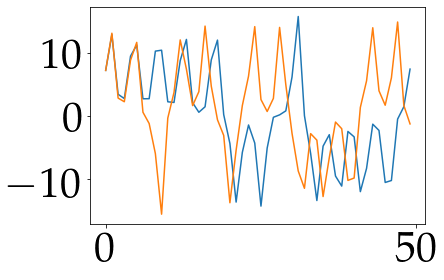

In [287]:
plt.plot(S_NODE_Adap.cpu().detach()[:50,0,0])
plt.plot(xt.values[:50,0])

## 4.3) Neural ODE with trainable integration scheme 

We first define a parameterization of the data-driven ODE
\begin{equation}
     \dot{{z}}_{t} = f_{\theta_{NN}}(t,{z}_{t})
     \label{EQ:sec3_ODE_eq_DD}
\end{equation}
in a differentiable framework, which usually corresponds to the definition of a neural network architecture with parameters $\theta_{NN}$. This archictecture may rely on physics-informed parameterizations or  on fully data-driven formulations. Regarding the numerical integration of the ODE, we aim to apply a trainable  $q$-stage Runge-Kutta scheme $\mathcal{ADRK}_q$. 

Here, we aim to jointly learn the parameters of the ADRK integration scheme as well as of the ODE, such that the set of trainable parameters $\Theta$ are given by
\begin{equation}
\label{EQ:trainable_params_DD}
\begin{split}
\Theta &= \{\mathcal{ADRK}_q, \theta_{NN} \}
\end{split}
\end{equation}

Similarly to the previous case-study, the training procedure comes to optimize all trainable parameters with a view to minimizing the forecasting error from a predefined initial condition, which leads to the following training loss:
\begin{equation}
\label{EQ:cost_function_DD}
\begin{split}
\mathcal{L}(\Theta) &= \displaystyle \sum_{n=1}^N \| {z}_{t_{n}} - \Phi_{\mathcal{ADRK}_q,\theta_{NN},t_n}({z}_{t_{n-1}})\|  
\end{split}
\end{equation}
with $\Phi_{\mathcal{ADRK}_q,\theta_{NN},t_n}({z}_{t_{n-1}})$ the numerical ADRK integration of of the NODE model.

In [247]:
device = 'cpu'
params_ADRK = {}#NN parameters 
params_ADRK['transition_layers']=1
params_ADRK['bi_linear_layers']=3
params_ADRK['dim_hidden_linear'] = 3
params_ADRK['dim_input']=3
params_ADRK['dim_observations'] = 3
params_ADRK['dim_output']=3
params_ADRK['dim_hidden']=3
params_ADRK['dt_integration']=GD.dt_integration
params_ADRK['ntrain']=[4000]
params_ADRK['pretrained']=False
params_ADRK['nb_stages'] = 8
params_ADRK['path']='ADRK_Lorenz_dt_01'

In [248]:
class applyRK_Constraints(object):
        def __init__(self, frequency=1):
            self.frequency = frequency
    
        def __call__(self, module):
            if hasattr(module, 'b'):
                module.b.data = (torch.abs(module.b.data))
                module.b.data  =  ((module.b.data) / (module.b.data).sum(1,keepdim = True).expand_as(module.b.data))
            if hasattr(module, 'c'):
                module.c.data = module.c.data
                module.c.data[:,0] = 0
                module.c.data = module.c.data.sub_(torch.min(module.c.data)).div_(torch.max(module.c.data) - torch.min(module.c.data)).sort()[0]
                

class NODE_model_ADRK(torch.nn.Module):
        def __init__(self, params):
            super(NODE_model_ADRK, self).__init__()
            self.linearCell   = torch.nn.Linear(params_ADRK['dim_input'], params_ADRK['dim_hidden_linear']).to(device) 
            self.BlinearCell1 = torch.nn.ModuleList([torch.nn.Linear(params_ADRK['dim_input'], 1).to(device) for i in range(params_ADRK['bi_linear_layers'])])
            self.BlinearCell2 = torch.nn.ModuleList([torch.nn.Linear(params_ADRK['dim_input'], 1).to(device) for i in range(params_ADRK['bi_linear_layers'])])
            augmented_size    = params_ADRK['bi_linear_layers'] + params_ADRK['dim_hidden_linear']
            self.transLayers = torch.nn.ModuleList([torch.nn.Linear(augmented_size, params_ADRK['dim_output']).to(device)])
            self.transLayers.extend([torch.nn.Linear(params_ADRK['dim_output'], params_ADRK['dim_output']).to(device) for i in range(1, params_ADRK['transition_layers'])])
            self.outputLayer  = torch.nn.Linear(params_ADRK['dim_output'], params_ADRK['dim_output']).to(device)
        def forward(self, inp):
            BP_outp = (torch.zeros((inp.size()[0],params_ADRK['bi_linear_layers'])).to(device))
            L_outp   = self.linearCell(inp)
            for i in range((params_ADRK['bi_linear_layers'])):
                BP_outp[:,i]=self.BlinearCell1[i](inp)[:,0]*self.BlinearCell2[i](inp)[:,0]
            aug_vect = torch.cat((L_outp, BP_outp), dim=1)
            for i in range((params_ADRK['transition_layers'])):
                aug_vect = (self.transLayers[i](aug_vect))
            grad = self.outputLayer(aug_vect)
            return grad
model  = NODE_model_ADRK(params).to(device)

class INT_net(torch.nn.Module):
        def __init__(self, params,order):
            super(INT_net, self).__init__()
            self.Dyn_net = model
            a = 0.*np.tril(np.random.uniform(size=(1,order,order)),k=-1)
            b = 0.*np.random.uniform(size=(1,order))
            c = 0.01*np.random.uniform(size=(1,order))
            self.a = torch.nn.Parameter(torch.from_numpy(a[:,:,:]).float().to(device),requires_grad = True).to(device)
            self.b = torch.nn.Parameter(torch.from_numpy(b).float().to(device),requires_grad = True).to(device)
            self.c = torch.nn.Parameter(torch.from_numpy(c).float().to(device),requires_grad = True).to(device)
         
        def forward(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            return pred ,k[0], inp

In [249]:
x = (torch.from_numpy(catalog.analogs).float().to(device).unsqueeze(0))
y = (torch.from_numpy(catalog.successors).float().to(device).unsqueeze(0))
flow_map = INT_net(params,params_ADRK['nb_stages']).to(device)
if params_ADRK['pretrained'] :
    flow_map.load_state_dict(torch.load(params_ADRK['path']+'.pt'))
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(flow_map.parameters(), lr = 0.001)

In [250]:
clipper = applyRK_Constraints()
print ('Learning dynamical model')
for t in range(params_ADRK['ntrain'][0]):
        for b in range(x.shape[0]):
            # Forward pass: Compute predicted gradients by passing x to the model
            pred ,grad , inp = flow_map(x[b,:,:],params_ADRK['dt_integration'],params_ADRK['nb_stages'])
            # Compute and print loss
            loss = criterion(pred, y[b,:,:])
            if not False:
                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad() 
                loss.backward()
                optimizer.step()
                #torch.nn.utils.clip_grad_norm_(modelRINN.parameters(),5)
                #for p in modelRINN.parameters():
                #    p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))
                #modelRINN.apply(clipper)
                torch.save(flow_map.state_dict(), params_ADRK['path']+'.pt')
                if t % clipper.frequency == 0:
                    flow_map.apply(clipper)
            print(t,loss.detach().numpy())

Learning dynamical model
0 100.27467
1 118.50522
2 117.96474
3 117.35858
4 116.736374
5 116.1156
6 115.504326
7 114.90662
8 114.32467
9 113.75961
10 113.21202
11 112.68206
12 112.16967
13 111.67459
14 111.196434
15 110.73469
16 110.28872
17 109.85789
18 109.44148
19 109.03875
20 108.649
21 108.27148
22 107.9055
23 107.550385
24 107.20552
25 106.87035
26 106.54434
27 106.22701
28 105.91789
29 105.61667
30 105.32288
31 105.03625
32 104.75646
33 104.483215
34 104.21627
35 103.95535
36 103.70021
37 103.45065
38 103.20645
39 102.9674
40 102.733315
41 102.50399
42 102.279236
43 102.05891
44 101.842804
45 101.63078
46 101.422676
47 101.218315
48 101.017586
49 100.82032
50 100.626396
51 100.435646
52 100.24797
53 100.06323
54 99.8813
55 99.70207
56 99.52543
57 99.35124
58 99.17942
59 99.009834
60 98.84241
61 98.67702
62 98.51357
63 98.35198
64 98.19212
65 98.03396
66 97.87736
67 97.72223
68 97.56851
69 97.416084
70 97.26491
71 97.11487
72 96.9659
73 96.81792
74 96.670845
75 96.524605
76 96.379

615 24.047625
616 23.99131
617 23.93521
618 23.879313
619 23.823618
620 23.768118
621 23.712818
622 23.657705
623 23.602776
624 23.548042
625 23.49349
626 23.439117
627 23.384932
628 23.330933
629 23.277111
630 23.223476
631 23.170029
632 23.11676
633 23.063684
634 23.01079
635 22.958084
636 22.905563
637 22.853226
638 22.801083
639 22.74912
640 22.69735
641 22.645763
642 22.594364
643 22.543154
644 22.49213
645 22.441286
646 22.390638
647 22.340164
648 22.289877
649 22.23977
650 22.18985
651 22.140104
652 22.090536
653 22.041145
654 21.991932
655 21.94289
656 21.894012
657 21.845308
658 21.79677
659 21.748396
660 21.700182
661 21.652132
662 21.604239
663 21.5565
664 21.508919
665 21.461489
666 21.414211
667 21.367075
668 21.320097
669 21.27419
670 21.227543
671 21.18195
672 21.135675
673 21.090408
674 21.044436
675 20.999607
676 20.953968
677 20.909431
678 20.864141
679 20.81997
680 20.774994
681 20.731195
682 20.686567
683 20.643091
684 20.598787
685 20.555716
686 20.511753
687 20.46

1197 9.86508
1198 9.8555765
1199 9.846107
1200 9.836649
1201 9.827223
1202 9.817807
1203 9.808423
1204 9.799048
1205 9.789703
1206 9.780367
1207 9.77106
1208 9.761762
1209 9.752492
1210 9.743229
1211 9.733994
1212 9.724762
1213 9.71556
1214 9.706365
1215 9.697193
1216 9.688025
1217 9.678885
1218 9.669748
1219 9.660637
1220 9.651531
1221 9.642472
1222 9.633395
1223 9.624358
1224 9.615313
1225 9.606302
1226 9.597282
1227 9.588294
1228 9.579302
1229 9.570336
1230 9.561364
1231 9.552425
1232 9.543472
1233 9.534553
1234 9.525623
1235 9.516722
1236 9.507813
1237 9.498931
1238 9.490042
1239 9.481177
1240 9.472304
1241 9.46346
1242 9.454601
1243 9.445771
1244 9.436929
1245 9.428112
1246 9.419286
1247 9.410482
1248 9.4016695
1249 9.392879
1250 9.384077
1251 9.3753
1252 9.366513
1253 9.357746
1254 9.34897
1255 9.340214
1256 9.331449
1257 9.322703
1258 9.313945
1259 9.305209
1260 9.296461
1261 9.287732
1262 9.278991
1263 9.270269
1264 9.261536
1265 9.25282
1266 9.24409
1267 9.235384
1268 9.226663

1775 5.6628385
1776 5.6564074
1777 5.6494856
1778 5.6430717
1779 5.6361947
1780 5.629787
1781 5.622958
1782 5.6165357
1783 5.6097345
1784 5.6032596
1785 5.5964503
1786 5.5898967
1787 5.583076
1788 5.5765004
1789 5.56976
1790 5.5633683
1791 5.5569506
1792 5.5511127
1793 5.5452375
1794 5.5401535
1795 5.534219
1796 5.5286345
1797 5.520617
1798 5.5128503
1799 5.504118
1800 5.4981036
1801 5.4931407
1802 5.489942
1803 5.485194
1804 5.4770455
1805 5.467032
1806 5.458655
1807 5.4533334
1808 5.4494953
1809 5.442754
1810 5.4346347
1811 5.426386
1812 5.4214253
1813 5.4166203
1814 5.410028
1815 5.401743
1816 5.394892
1817 5.3895555
1818 5.3842487
1819 5.3767076
1820 5.369708
1821 5.363628
1822 5.358458
1823 5.3517423
1824 5.344729
1825 5.338305
1826 5.3329725
1827 5.326574
1828 5.3198543
1829 5.31328
1830 5.3078723
1831 5.3016667
1832 5.295127
1833 5.288548
1834 5.2829976
1835 5.276863
1836 5.2704954
1837 5.2639613
1838 5.258382
1839 5.2522573
1840 5.2460046
1841 5.2395563
1842 5.2339244
1843 5.22

2340 1.9170742
2341 1.9107524
2342 1.904995
2343 1.9001234
2344 1.8939495
2345 1.8883728
2346 1.8835297
2347 1.8775188
2348 1.8720921
2349 1.8673787
2350 1.8614824
2351 1.8562962
2352 1.8516662
2353 1.8459508
2354 1.8408872
2355 1.8363397
2356 1.8307714
2357 1.8258891
2358 1.8214295
2359 1.8160399
2360 1.8112887
2361 1.8069174
2362 1.8016607
2363 1.7970377
2364 1.7927268
2365 1.7875954
2366 1.7831064
2367 1.7788746
2368 1.7738844
2369 1.7695124
2370 1.765344
2371 1.7604707
2372 1.756225
2373 1.7521344
2374 1.747395
2375 1.7432505
2376 1.7392246
2377 1.7346057
2378 1.7305716
2379 1.7266165
2380 1.7221142
2381 1.7181784
2382 1.7142855
2383 1.7098945
2384 1.706056
2385 1.7022268
2386 1.6979512
2387 1.6942055
2388 1.6904501
2389 1.6862891
2390 1.6826391
2391 1.6789525
2392 1.6749046
2393 1.6713418
2394 1.6677301
2395 1.6637956
2396 1.6603267
2397 1.6567872
2398 1.6529611
2399 1.6495763
2400 1.6461087
2401 1.6423889
2402 1.6390852
2403 1.6356895
2404 1.6320726
2405 1.6288496
2406 1.6255218


2889 0.9178443
2890 0.91705203
2891 0.9162767
2892 0.91542155
2893 0.91450596
2894 0.9136257
2895 0.91284275
2896 0.9120765
2897 0.9112277
2898 0.91032535
2899 0.9094588
2900 0.9086881
2901 0.9079261
2902 0.9070866
2903 0.90619546
2904 0.905345
2905 0.90458184
2906 0.90382725
2907 0.9029958
2908 0.9021183
2909 0.9012792
2910 0.90052587
2911 0.8997765
2912 0.89895403
2913 0.8980885
2914 0.89726764
2915 0.89651585
2916 0.8957718
2917 0.8949574
2918 0.8941075
2919 0.8933047
2920 0.8925554
2921 0.8918127
2922 0.8910079
2923 0.89017296
2924 0.8893868
2925 0.8886383
2926 0.8879
2927 0.8871049
2928 0.88628465
2929 0.8855143
2930 0.8847671
2931 0.88403225
2932 0.8832458
2933 0.88243985
2934 0.8816843
2935 0.8809396
2936 0.88020825
2937 0.8794309
2938 0.878639
2939 0.8778982
2940 0.8771541
2941 0.87642205
2942 0.87565917
2943 0.87489194
2944 0.87414926
2945 0.8734053
2946 0.87268096
2947 0.8719282
2948 0.871173
2949 0.87044626
2950 0.86971027
2951 0.86897296
2952 0.868236
2953 0.8675081
2954 0.

3428 0.6214463
3429 0.62106216
3430 0.62067837
3431 0.620295
3432 0.61991185
3433 0.6195287
3434 0.6191467
3435 0.61876476
3436 0.6183839
3437 0.6180023
3438 0.61762124
3439 0.6172411
3440 0.61686164
3441 0.6164826
3442 0.61610365
3443 0.6157243
3444 0.61534643
3445 0.61496866
3446 0.6145919
3447 0.6142151
3448 0.6138381
3449 0.6134616
3450 0.61308664
3451 0.61271167
3452 0.6123369
3453 0.61196214
3454 0.6115876
3455 0.61121464
3456 0.610842
3457 0.6104691
3458 0.6100963
3459 0.60972416
3460 0.60935265
3461 0.6089824
3462 0.6086119
3463 0.6082408
3464 0.6078707
3465 0.60750157
3466 0.60713345
3467 0.6067648
3468 0.6063961
3469 0.60602796
3470 0.60566103
3471 0.60529464
3472 0.6049279
3473 0.604562
3474 0.6041954
3475 0.6038301
3476 0.60346615
3477 0.60310215
3478 0.6027376
3479 0.602373
3480 0.60201025
3481 0.60164803
3482 0.60128635
3483 0.60092425
3484 0.6005618
3485 0.60020053
3486 0.5998409
3487 0.5994813
3488 0.5991209
3489 0.59876096
3490 0.5984016
3491 0.5980437
3492 0.5976861
3

3962 0.47457698
3963 0.47515854
3964 0.47488034
3965 0.47429276
3966 0.47451285
3967 0.4738618
3968 0.47433552
3969 0.47353214
3970 0.47361454
3971 0.47392863
3972 0.47286022
3973 0.47343197
3974 0.47289184
3975 0.4727682
3976 0.47262377
3977 0.47215512
3978 0.4727368
3979 0.47162968
3980 0.4720852
3981 0.47198457
3982 0.47125825
3983 0.47156984
3984 0.4709387
3985 0.47128963
3986 0.47065735
3987 0.47060975
3988 0.47100142
3989 0.46991616
3990 0.47051653
3991 0.4700237
3992 0.46980062
3993 0.46973267
3994 0.46922234
3995 0.46979922
3996 0.4687557
3997 0.46913478
3998 0.46911207
3999 0.4683519


In [255]:
nb_steps_pred = xt.values.shape[0]
t_pred = nb_steps_pred * params_ADRK['dt_integration']
S_NODE_ADRK = [torch.from_numpy(xt.values[:1,:]).float().to(device)]
for i in range(1,nb_steps_pred):
    S_NODE_ADRK.append(flow_map(S_NODE_ADRK[-1],params_ADRK['dt_integration'],params_ADRK['nb_stages'])[0])
S_NODE_ADRK = torch.stack(S_NODE_ADRK)

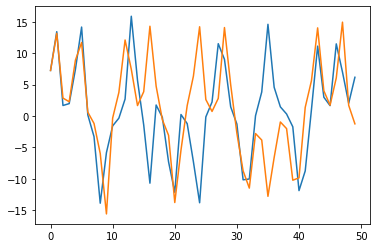

In [256]:
plt.plot(S_NODE_ADRK.cpu().detach()[:50,0,0])
plt.plot(xt.values[:50,0])

/homes/s17ouala/miniconda3/envs/DYN_ID2/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


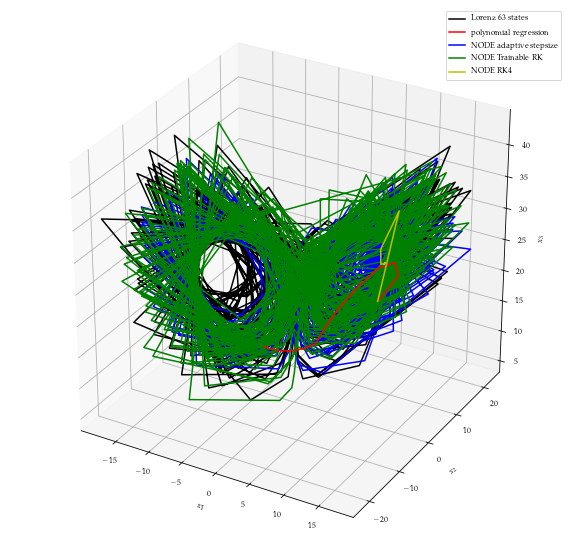

In [297]:
# plot
fig=plt.figure(figsize=(10,10))
ax=fig.gca(projection='3d')
line1,=ax.plot(xt.values[:,0],xt.values[:,1],xt.values[:,2],'k')
line3,=ax.plot(S_NODE_Adap.cpu().detach()[:,0,0],S_NODE_Adap.cpu().detach()[:,0,1],S_NODE_Adap.cpu().detach()[:,0,2],'b')
line4,=ax.plot(S_NODE_ADRK.cpu().detach()[:,0,0],S_NODE_ADRK.cpu().detach()[:,0,1],S_NODE_ADRK.cpu().detach()[:,0,2],'g')
line2,=ax.plot(S_Poly_sparse_data[:,0],S_Poly_sparse_data[:,1],S_Poly_sparse_data[:,2],'r')
line5,=ax.plot(S_NODE_RK4.cpu().detach()[:,0,0],S_NODE_RK4.cpu().detach()[:,0,1],S_NODE_RK4.cpu().detach()[:,0,2],'y')

ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1,line2,line3,line4,line5], ['Lorenz 63 states', 'polynomial regression', 'NODE adaptive stepsize', 'NODE Trainable RK', 'NODE RK4'])

# FUN : Stability analysis of the trained integration scheme

In [289]:
#extracting integration scheme params
a=flow_map.a.clone().data.numpy()[0,:,:]
b=flow_map.b.clone().data.numpy()[0,:]
c=flow_map.c.clone().data.numpy()[0,:]

a[:,0] = c[:] - a[:,:].sum(axis = 1)

In [290]:
rz = np.arange(-10,10+0.000001,0.01)
iz = np.arange(-10,10+0.000001,0.01)
rz, iz = np.meshgrid(rz,iz)
z  = rz+iz*1.j

In [291]:
GRINN = np.zeros_like(z)*np.nan
list_g = []
list_x = []
list_y = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j]*np.dot(np.dot(b.T,np.linalg.inv(np.eye(a.shape[0])-z[i,j]*a)),np.ones_like(b)))
        if tmp<1:
            GRINN[i,j] = np.abs(1+z[i,j]*np.dot(np.dot(b.T,np.linalg.inv(np.eye(a.shape[0])-z[i,j]*a)),np.ones_like(b)))
            list_g.append(GRINN[i,j].real)
            list_x.append(z[i,j].real)
            list_y.append(z[i,j].imag)

100%|██████████| 2001/2001 [04:16<00:00,  7.81it/s]


In [266]:
GE = np.zeros_like(z)*np.nan
list_gE = []
list_xE = []
list_yE = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j])
        if tmp<1:
            GE[i,j] = tmp
            list_gE.append(GE[i,j].real)
            list_xE.append(z[i,j].real)
            list_yE.append(z[i,j].imag)

100%|██████████| 2001/2001 [00:11<00:00, 173.22it/s]


In [267]:
GRK4 = np.zeros_like(z)*np.nan
ark4 = np.array([[0,0,0,0],[1/2,0,0,0],[0,1/2,0,0],[0,0,1,0]])
brk4 = np.array([1/6,1/3,1/3,1/6])

list_gRK4 = []
list_xRK4 = []
list_yRK4 = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j]*np.dot(np.dot(brk4.T,np.linalg.inv(np.eye(ark4.shape[0])-z[i,j]*ark4)),np.ones_like(brk4)))
        if tmp<1:
            GRK4[i,j] = tmp
            list_gRK4.append(GRK4[i,j].real)
            list_xRK4.append(z[i,j].real)
            list_yRK4.append(z[i,j].imag)

100%|██████████| 2001/2001 [02:36<00:00, 12.81it/s]


/homes/s17ouala/miniconda3/envs/DYN_ID2/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/homes/s17ouala/miniconda3/envs/DYN_ID2/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


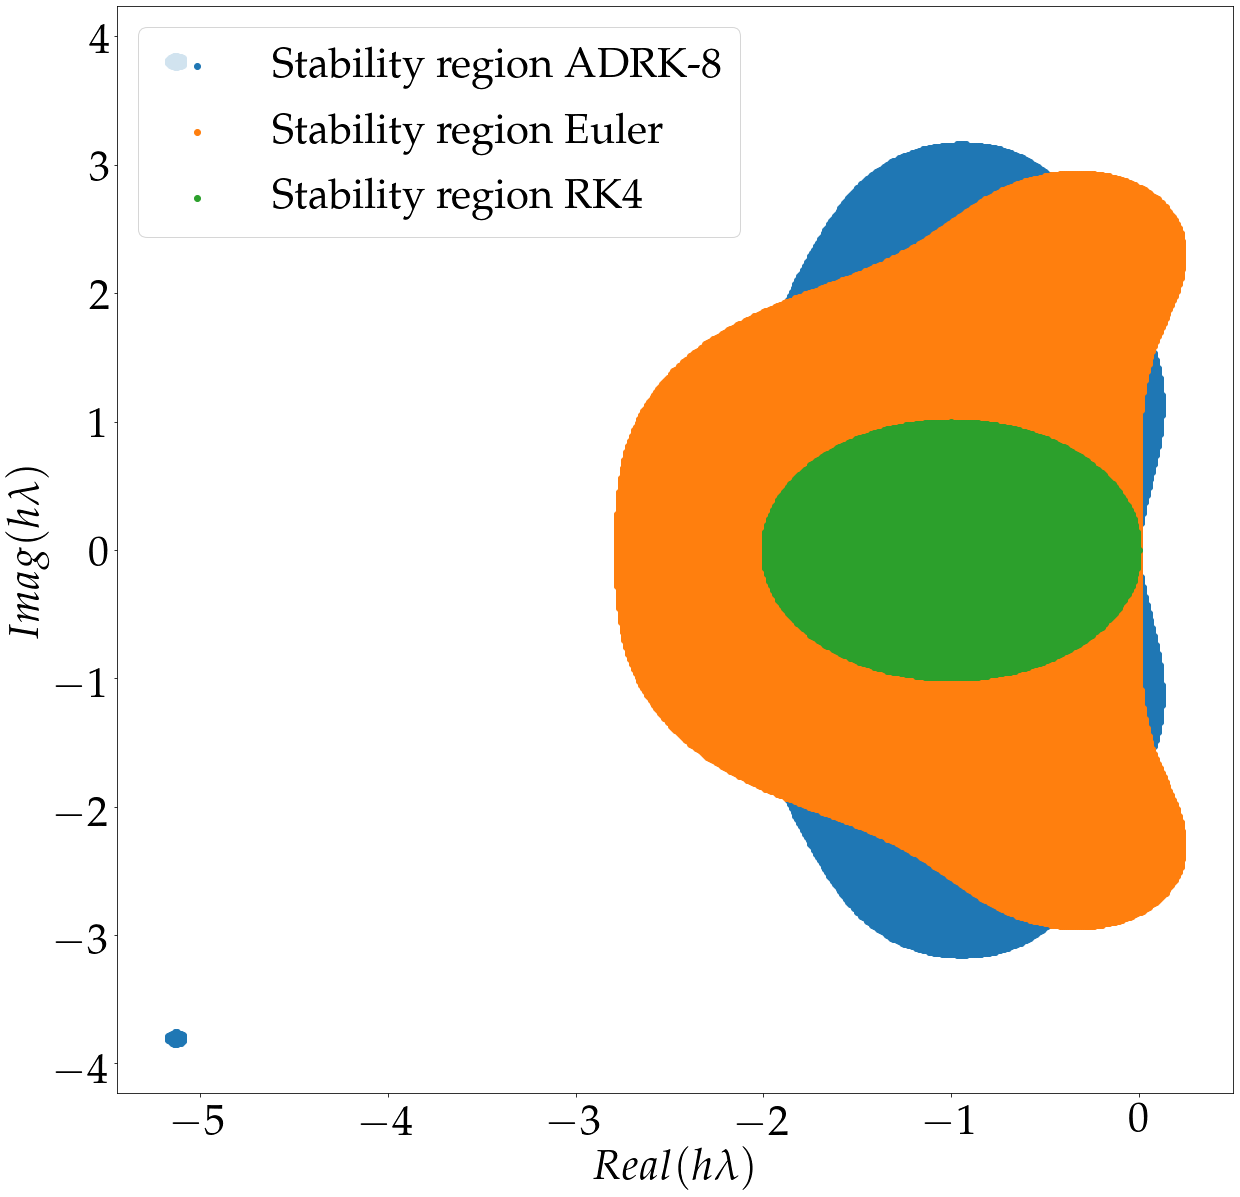

In [293]:
length_h = 1000
import matplotlib as mpl
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(20,20))
plt.scatter(np.array(list_x),np.array(list_y),label = 'Stability region ADRK-8')
plt.scatter(np.array(list_xRK4),np.array(list_yRK4),label = 'Stability region Euler')
plt.scatter(np.array(list_xE),np.array(list_yE),label = 'Stability region RK4')

plt.xlabel('$Real(h\lambda)$')
plt.ylabel('$Imag(h\lambda)$')

plt.legend()